In [9]:
import pickle
import matplotlib.pyplot as plt
import os
import cv2
import numpy as np
from projects.mmdet3d_plugin.datasets.utils import box3d_to_corners
pkl_path = 'work_dirs/sparsedrive_small_stage2/results-mini.pkl'

with open(pkl_path, 'rb') as f:
    result_all = pickle.load(f)
# result = result[0]['img_bbox']
    
color_mapping = np.asarray([
    [127, 24, 13],
    [147, 170, 0],
    [89, 51, 21],
    [241, 58, 19],
    [35, 44, 22],
    [112, 224, 255],
    [70, 184, 160],
    [153, 0, 255],
    [71, 255, 0],
    [255, 0, 163],
    [255, 204, 0],
    [0, 255, 235],
    [255, 0, 235],
    [255, 0, 122],
    [255, 245, 0],
    [10, 190, 212],
    [214, 255, 0],
    [0, 204, 255],
    [20, 0, 255],
    [255, 255, 0],
    [0, 153, 255],
    [0, 255, 204],
    [41, 255, 0],
    [173, 0, 255],
    [0, 245, 255],
    [71, 0, 255],
    [0, 255, 184],
    [0, 92, 255],
    [184, 255, 0],
    [255, 214, 0],
    [25, 194, 194],
    [92, 0, 255],
    [220, 220, 220],
    [255, 9, 92],
    [112, 9, 255],
    [8, 255, 214],
    [255, 184, 6],
    [10, 255, 71],
    [255, 41, 10],
    [7, 255, 255],
    [224, 255, 8],
    [102, 8, 255],
    [255, 61, 6],
    [255, 194, 7],
    [0, 255, 20],
    [255, 8, 41],
    [255, 5, 153],
    [6, 51, 255],
    [235, 12, 255],
    [160, 150, 20],
    [0, 163, 255],
    [140, 140, 140],
    [250, 10, 15],
    [20, 255, 0],
])


In [13]:
result_all[0]['img_bbox'].keys()

dict_keys(['boxes_3d', 'scores_3d', 'labels_3d', 'cls_scores', 'instance_ids', 'vectors', 'scores', 'labels', 'trajs_3d', 'trajs_score', 'anchor_queue', 'period', 'planning_score', 'planning', 'final_planning', 'ego_period', 'ego_anchor_queue'])

In [14]:
result_all[0]['img_bbox']['final_planning']

tensor([[ 0.1992,  3.7613],
        [ 0.5624,  7.3886],
        [ 1.2249, 11.0188],
        [ 2.1768, 14.6578],
        [ 3.4465, 18.1368],
        [ 5.0210, 21.4874]])

In [65]:
import matplotlib

CMD_LIST = ['Turn Right', 'Turn Left', 'Go Straight']

def draw_planning_pred(result, top_k=3):
    
    # import ipdb; ipdb.set_trace()
    plan_trajs = result['planning'].cpu().numpy()
    num_cmd = 3
    num_mode = plan_trajs.shape[1]
    plan_trajs_ = np.concatenate((np.zeros((num_cmd, num_mode, 1, 2)), plan_trajs), axis=2)
    plan_score_ = result['planning_score'].cpu().numpy()

    # cmd = data['gt_ego_fut_cmd'].argmax()
    result = []
    for cmd in range(3):
        plan_trajs = plan_trajs_[cmd]
        plan_score = plan_score_[cmd]

        sorted_ind = np.argsort(plan_score)[::-1]
      
        sorted_traj = plan_trajs[sorted_ind, :, :2]
        sorted_score = plan_score[sorted_ind]
        norm_score = np.exp(sorted_score[0])
        
        for j in range(top_k - 1, -1, -1):
            viz_traj = sorted_traj[j]
            traj_score = np.exp(sorted_score[j]) / norm_score
        result.append(render_traj(viz_traj, traj_score=traj_score,
                        colormap='autumn', dot_size=50))
    return result

def render_traj(
    future_traj, 
    traj_score=1, 
    colormap='winter', 
    points_per_step=20, 
    dot_size=25
):
    total_steps = (len(future_traj) - 1) * points_per_step + 1
    dot_colors = matplotlib.colormaps[colormap](
        np.linspace(0, 1, total_steps))[:, :3]
    dot_colors = dot_colors * traj_score + \
        (1 - traj_score) * np.ones_like(dot_colors)
    total_xy = np.zeros((total_steps, 2))
    for i in range(total_steps - 1):
        unit_vec = future_traj[i // points_per_step +
                                1] - future_traj[i // points_per_step]
        total_xy[i] = (i / points_per_step - i // points_per_step) * \
            unit_vec + future_traj[i // points_per_step]
    total_xy[-1] = future_traj[-1]

    return total_xy
    

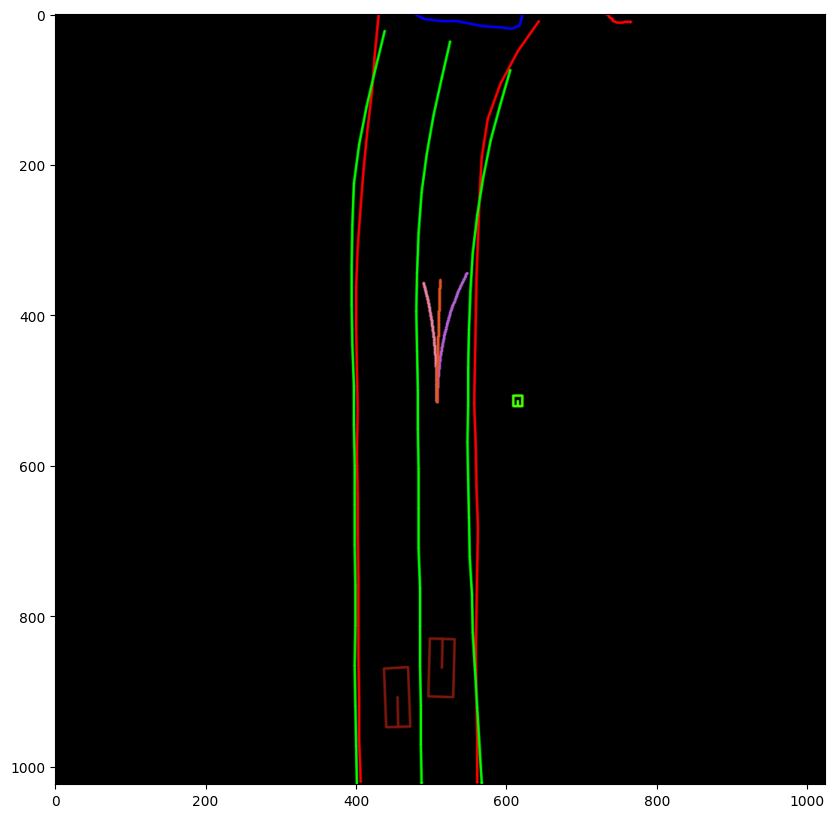

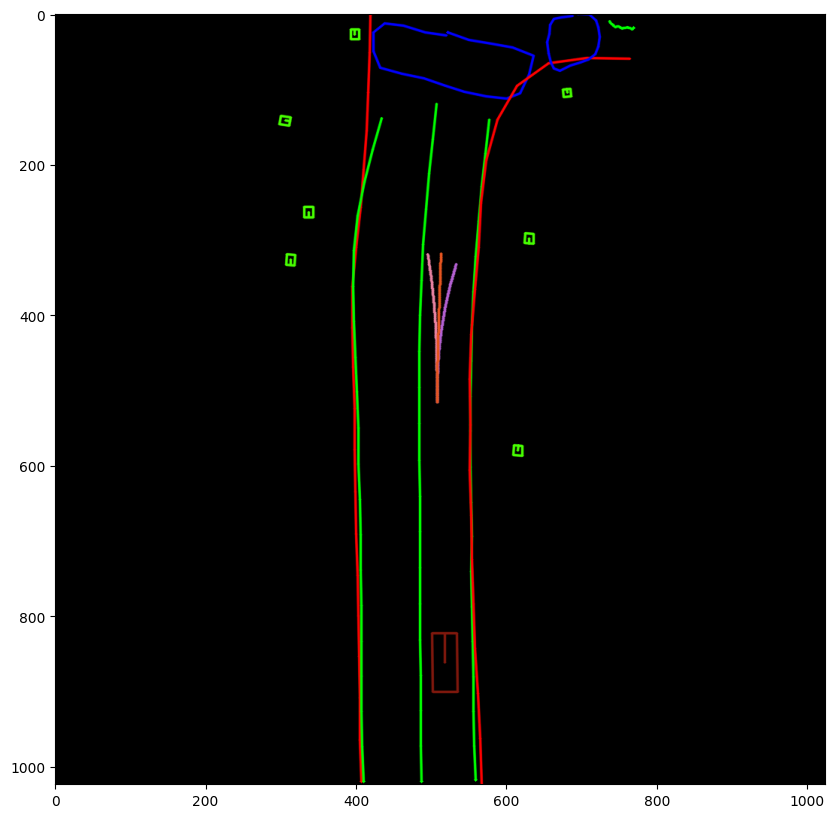

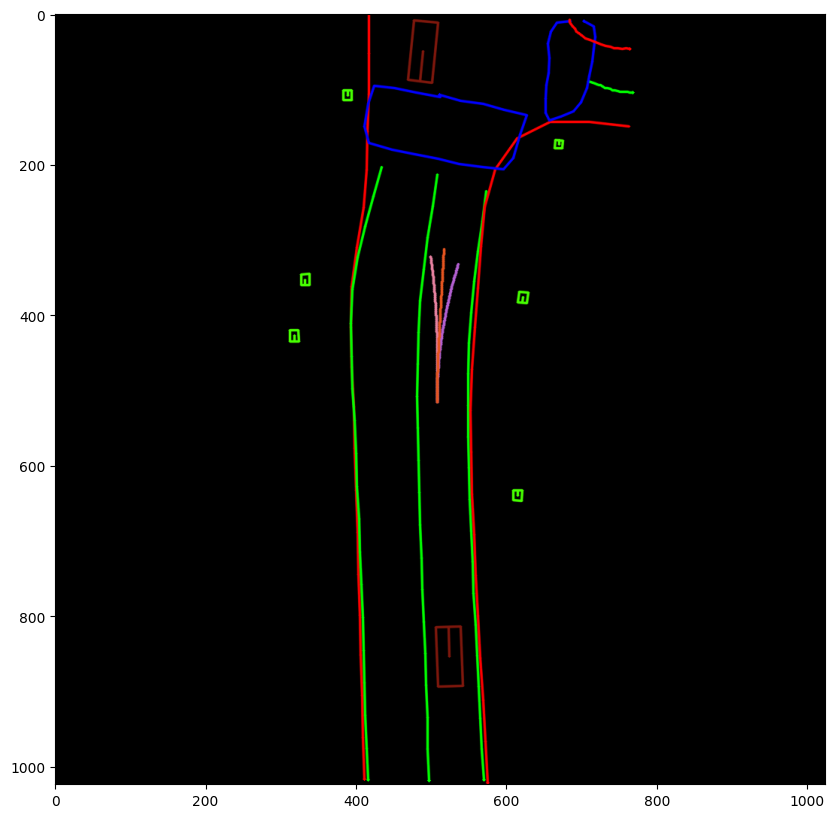

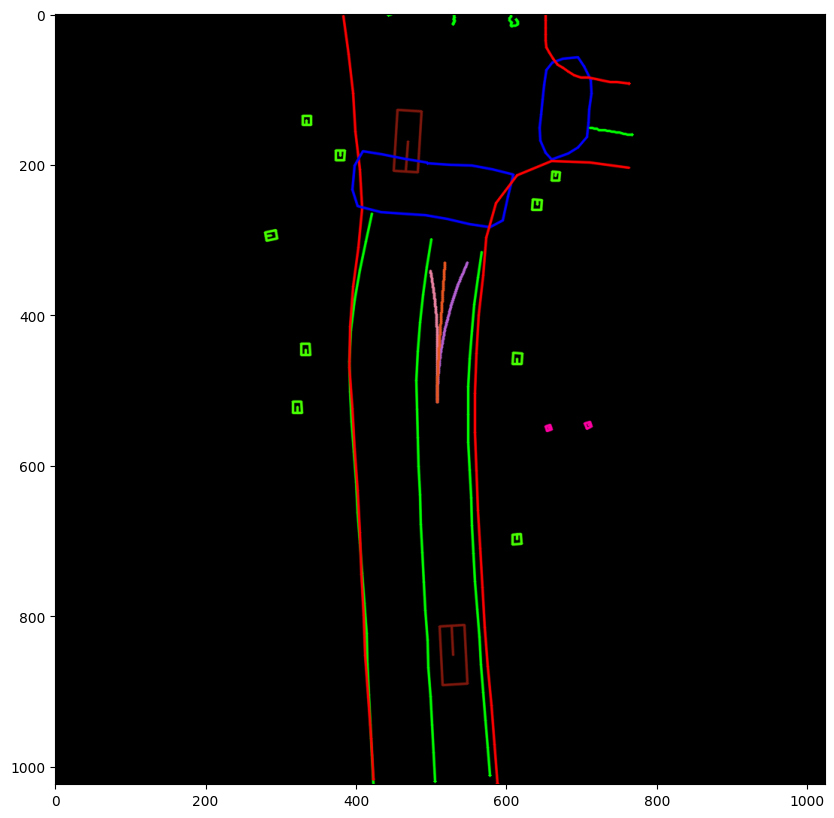

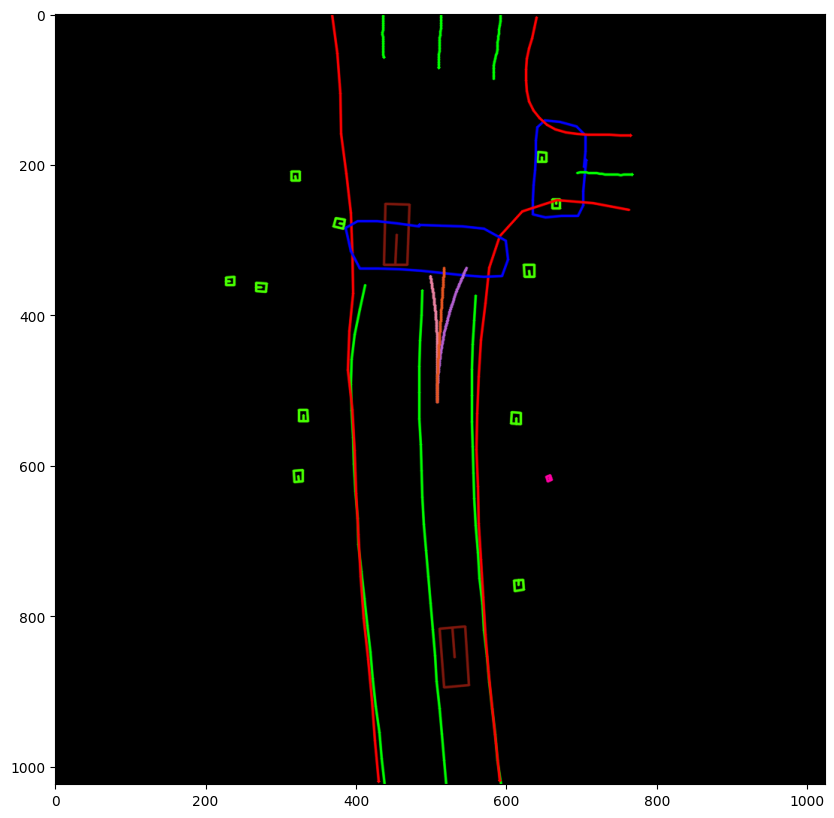

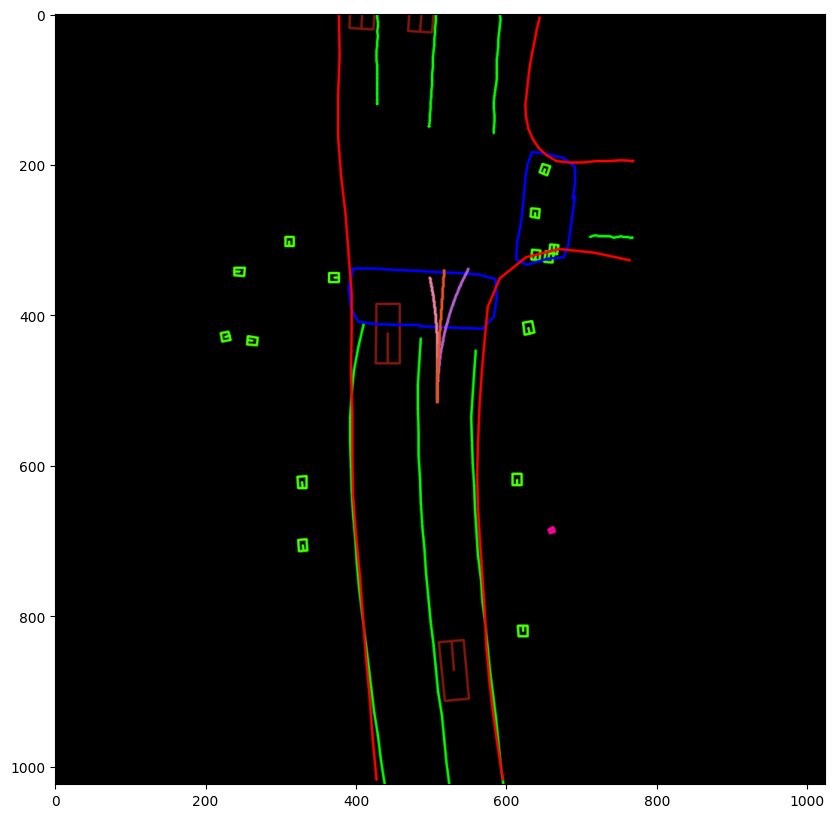

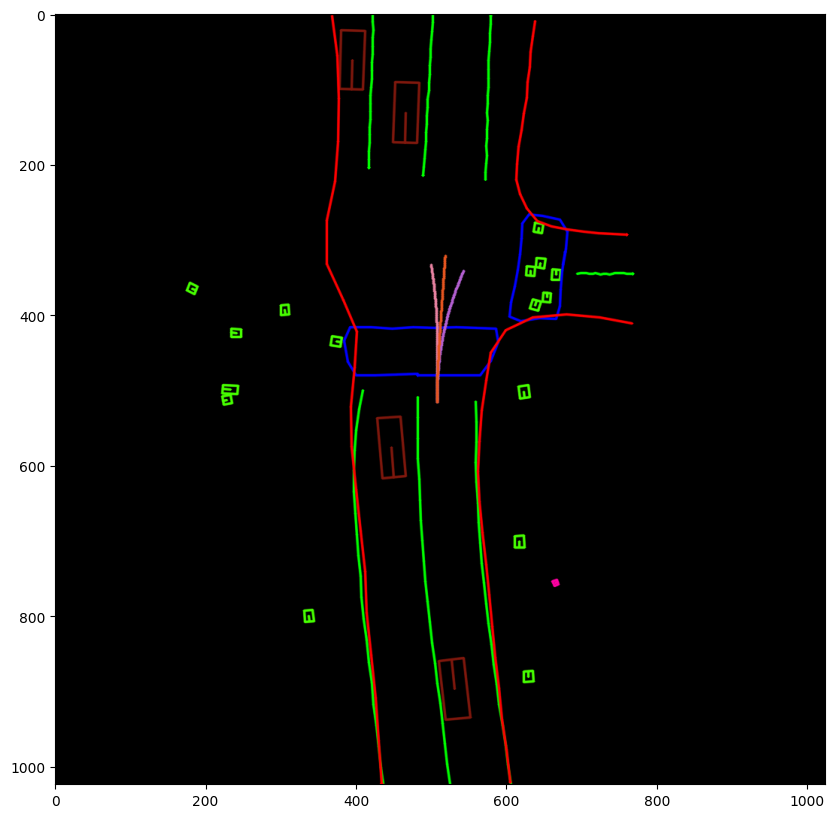

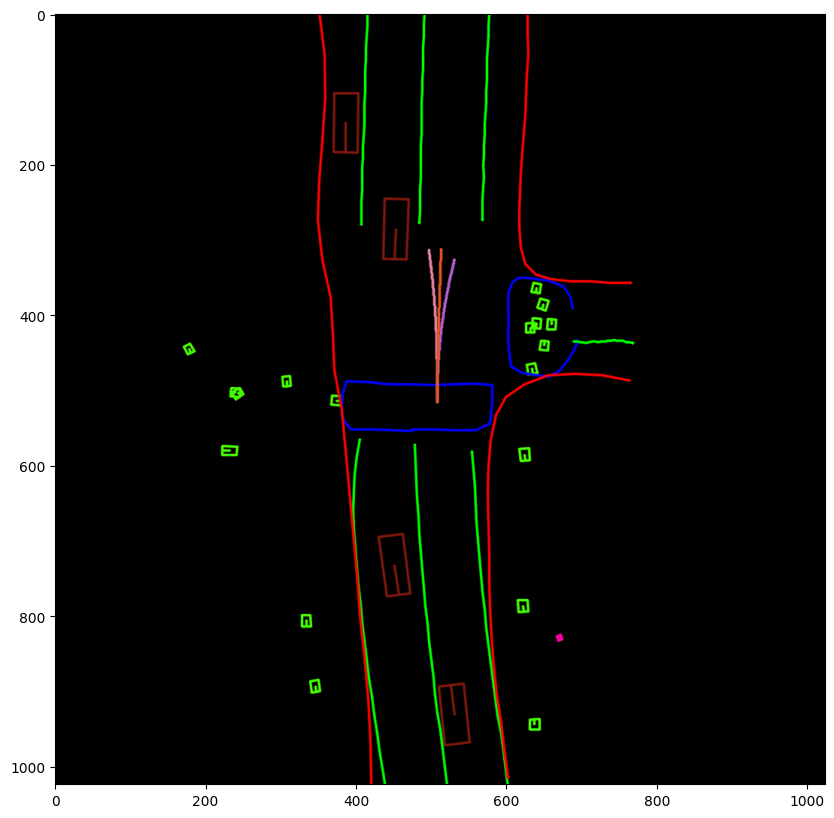

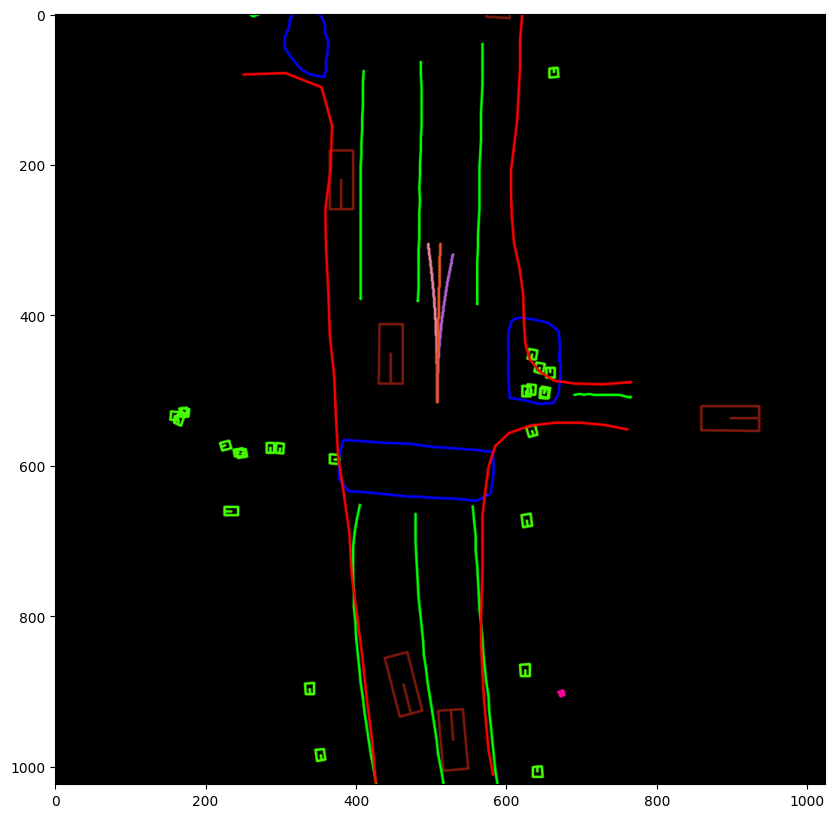

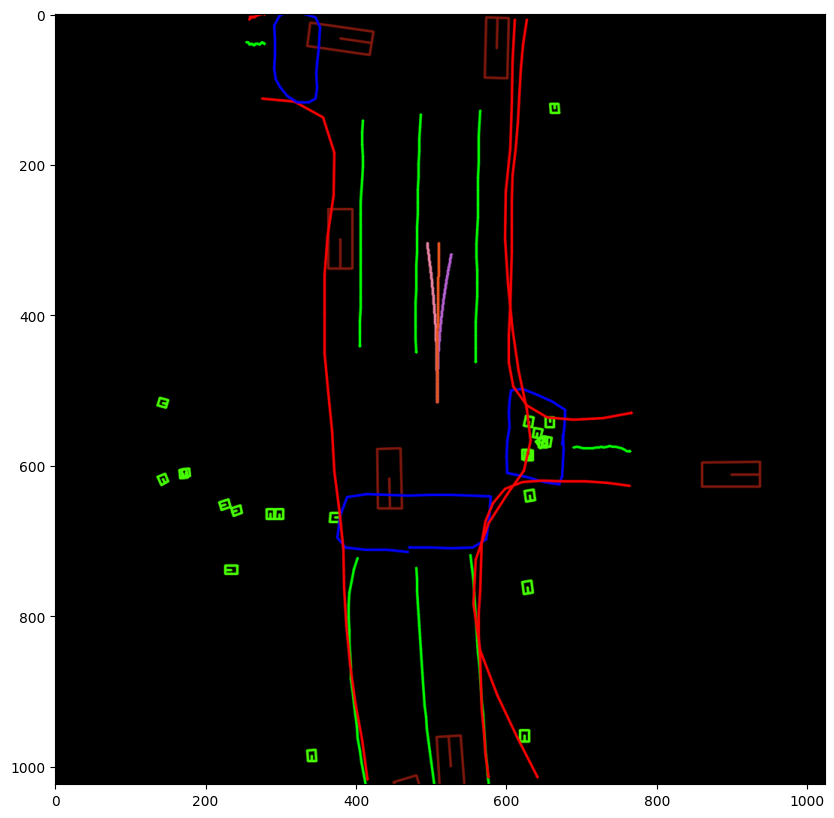

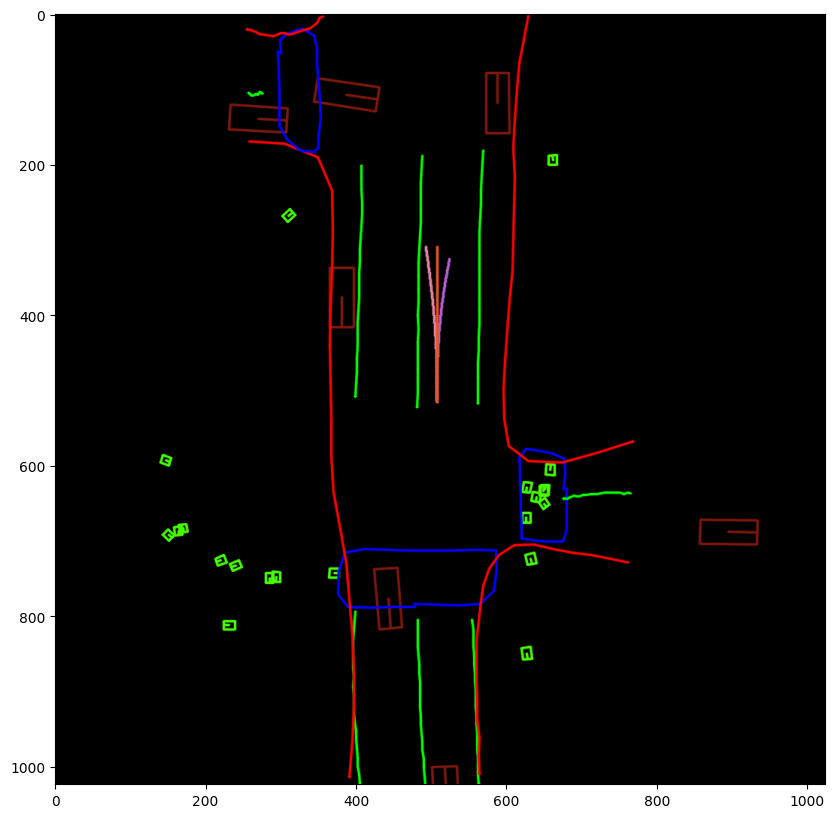

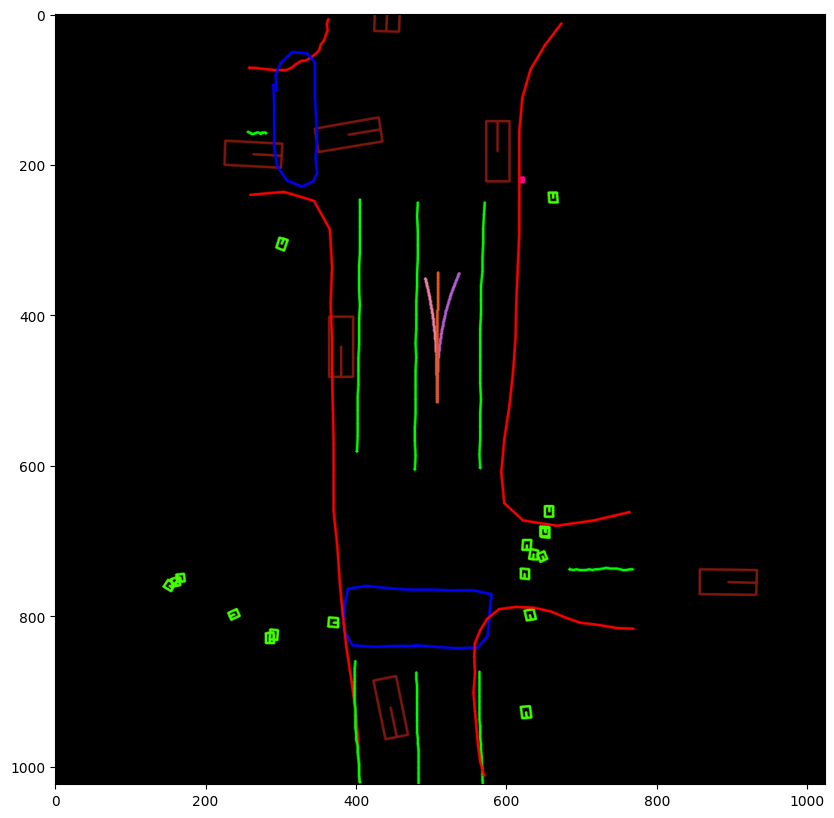

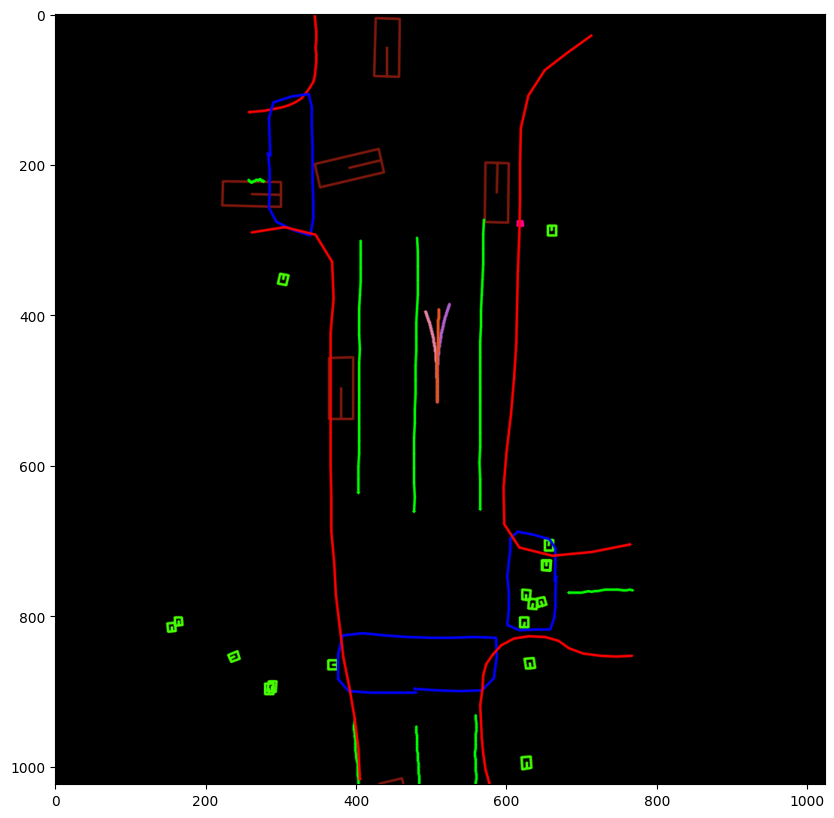

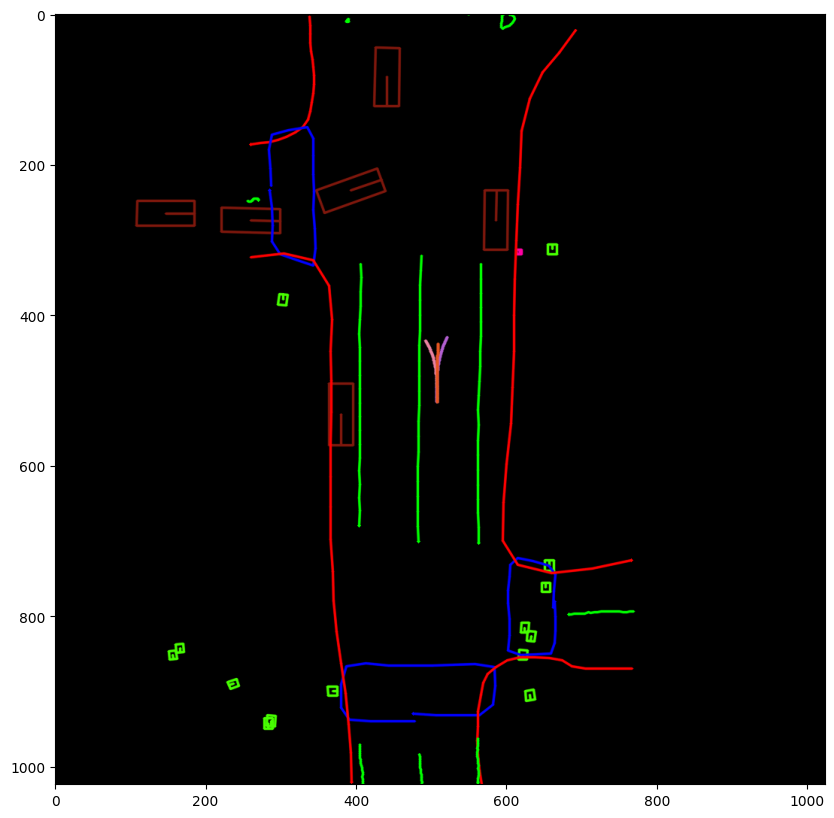

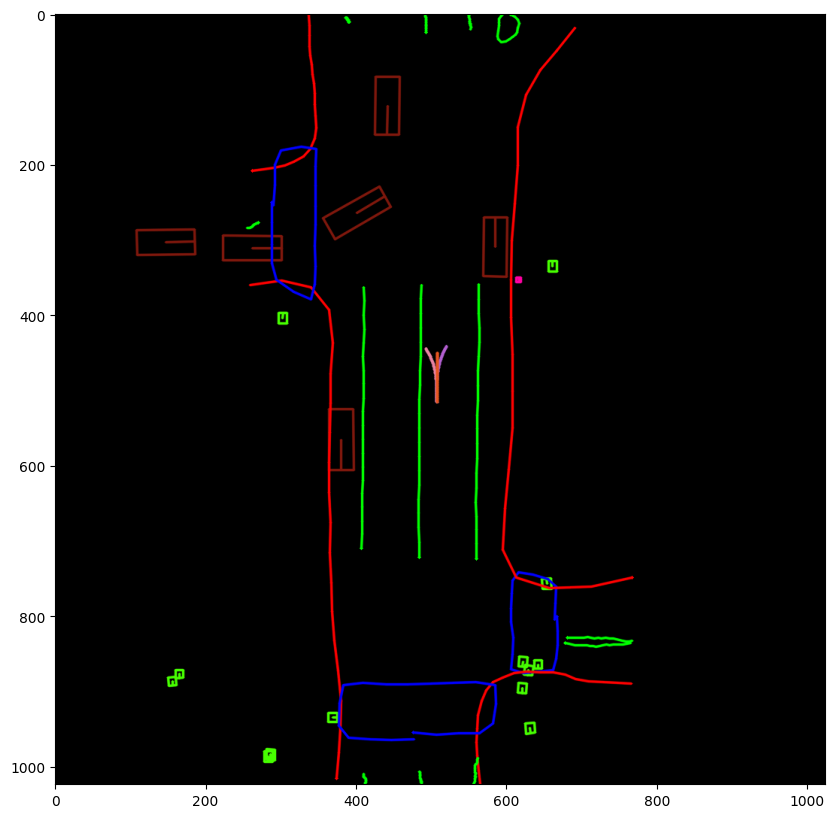

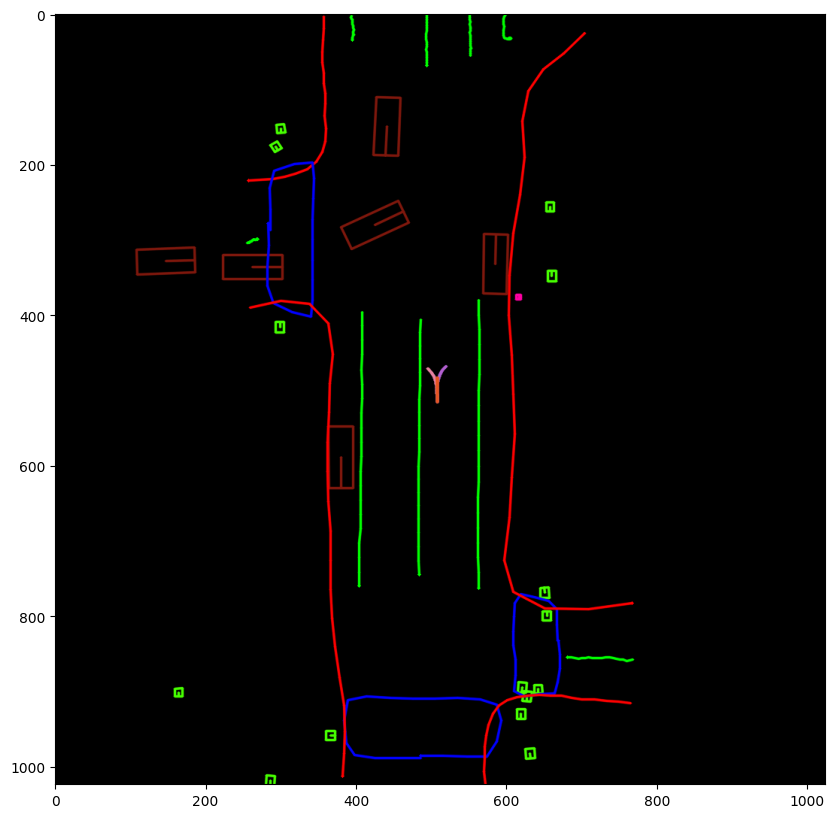

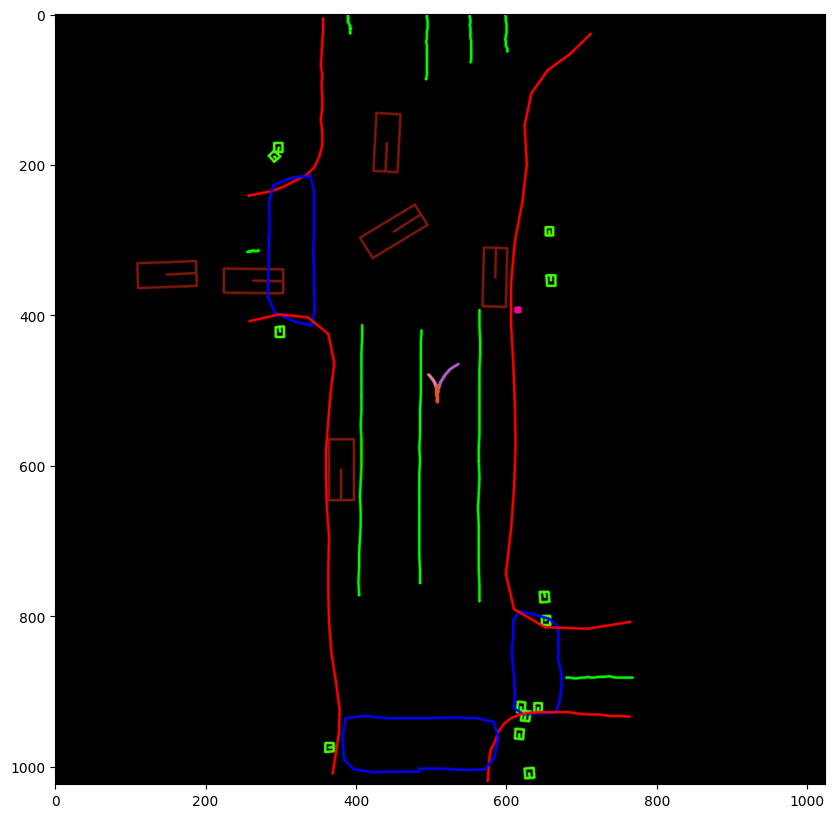

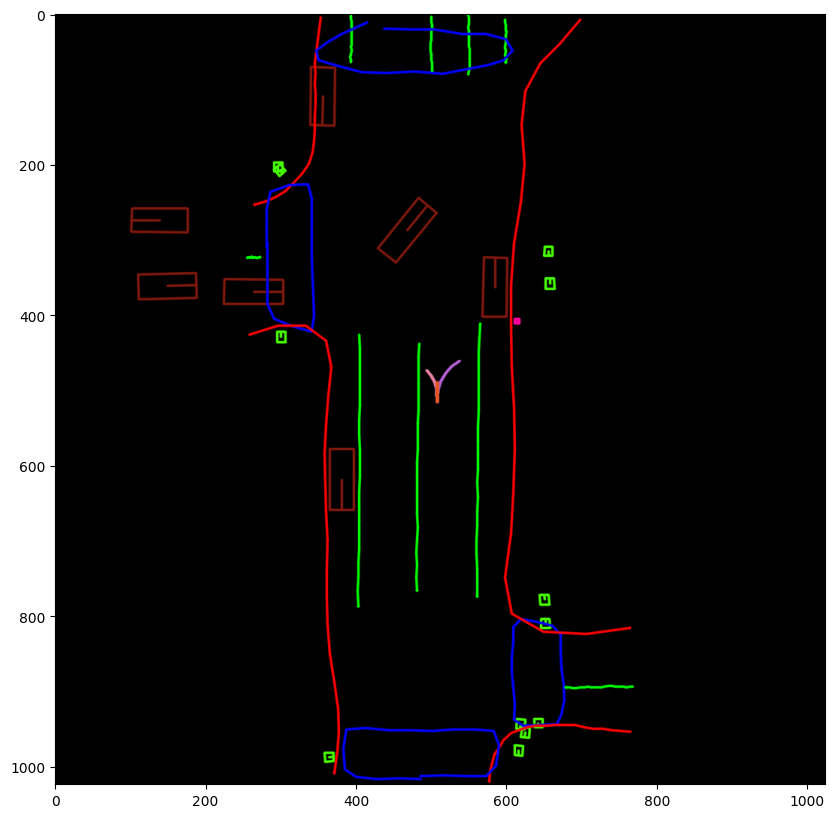

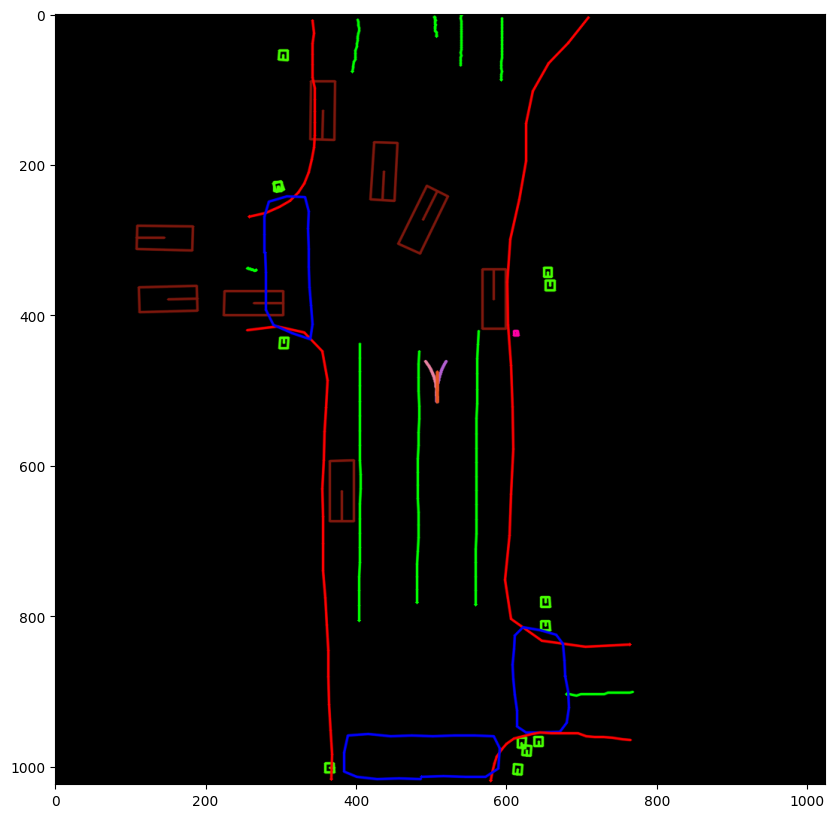

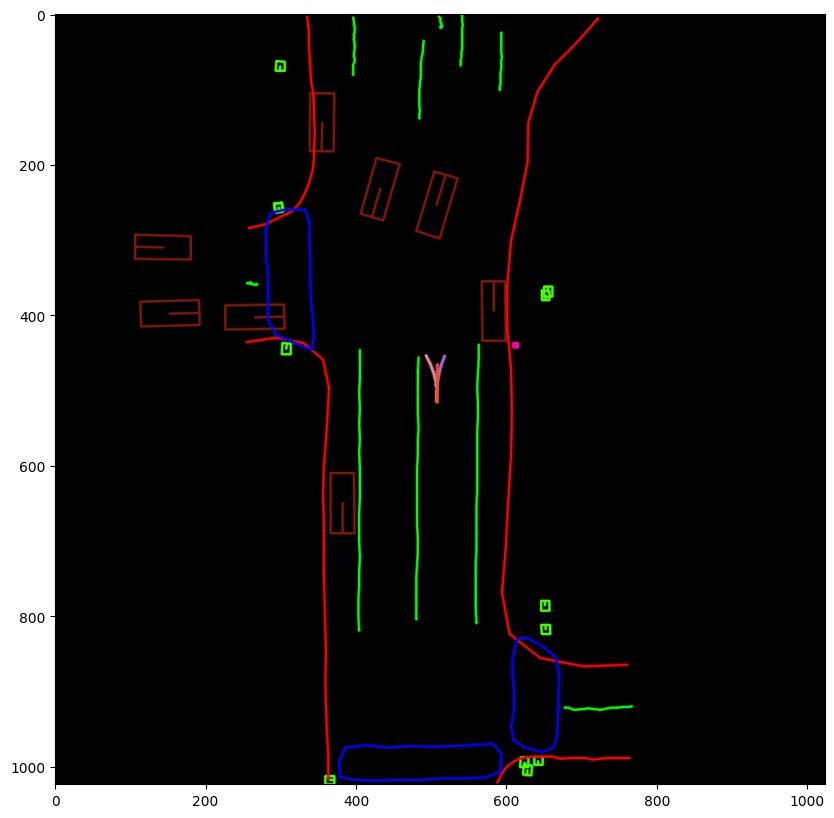

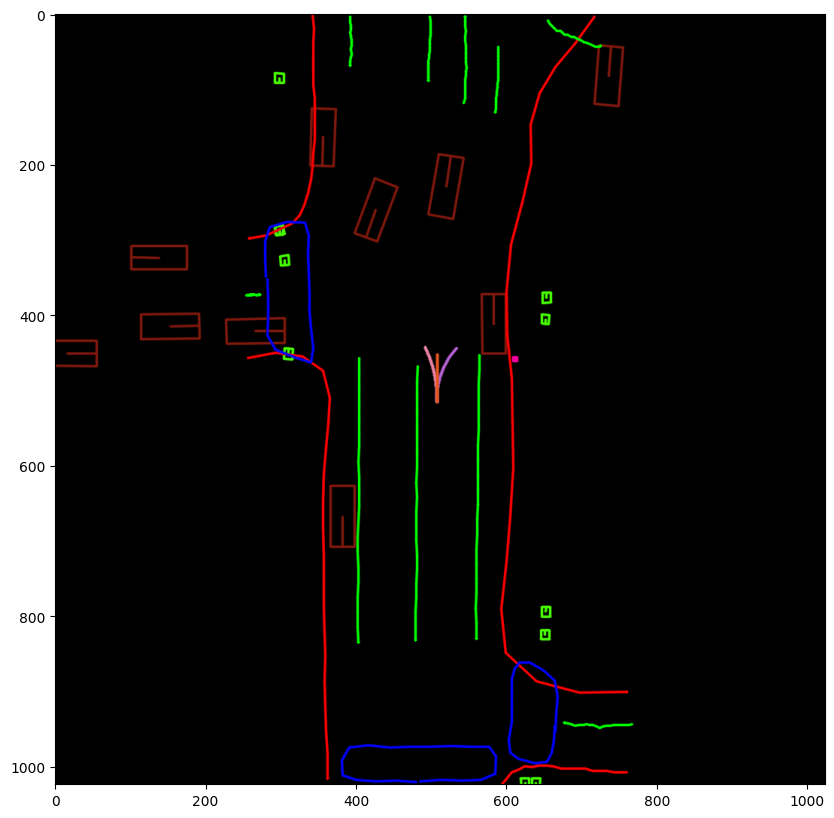

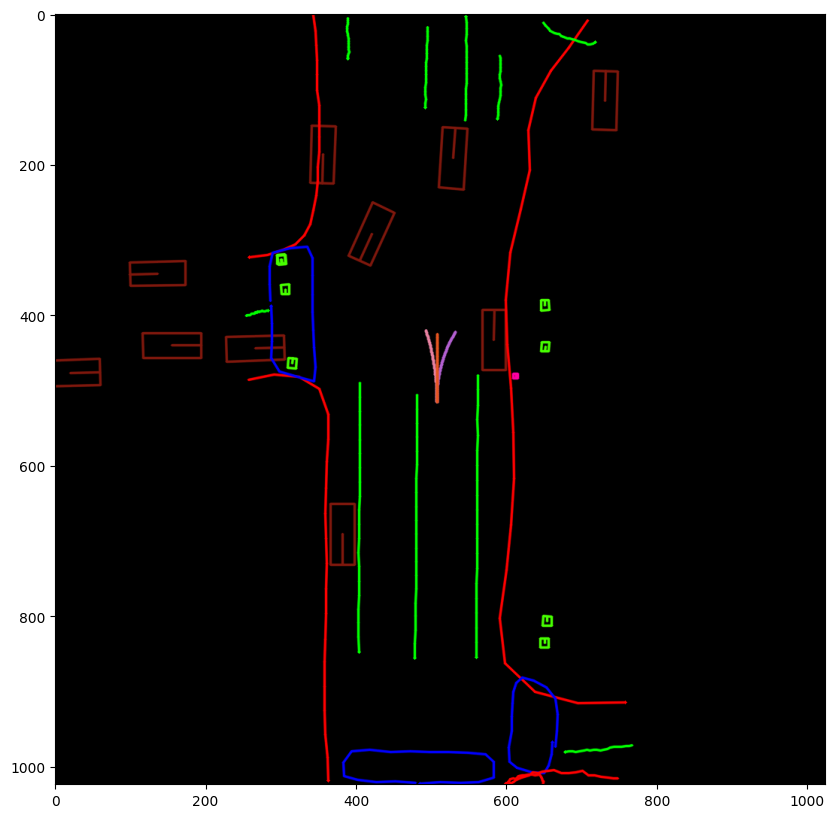

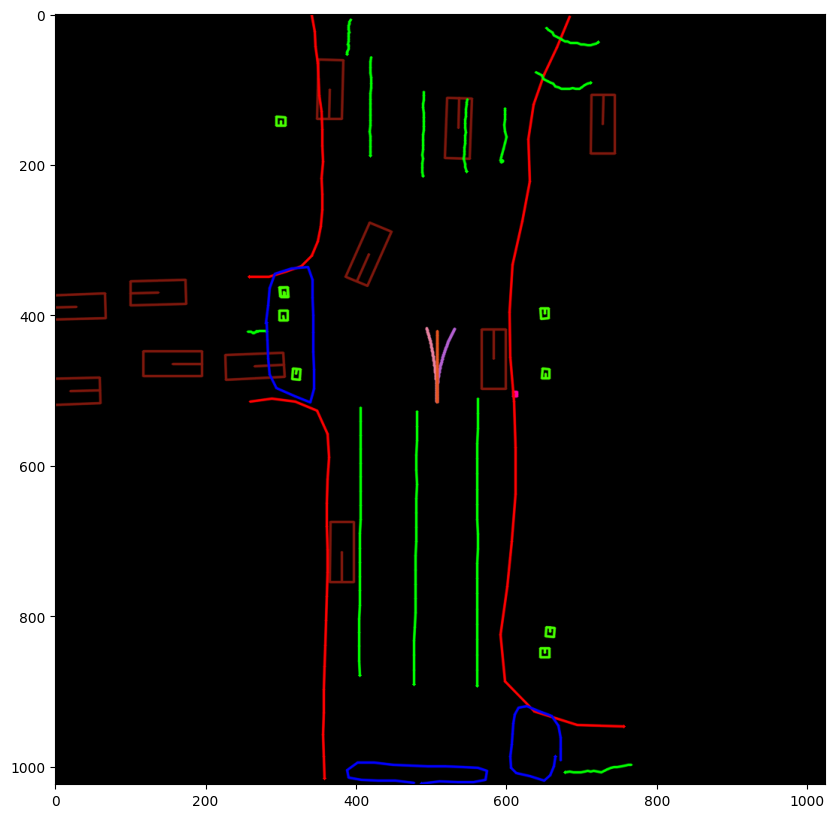

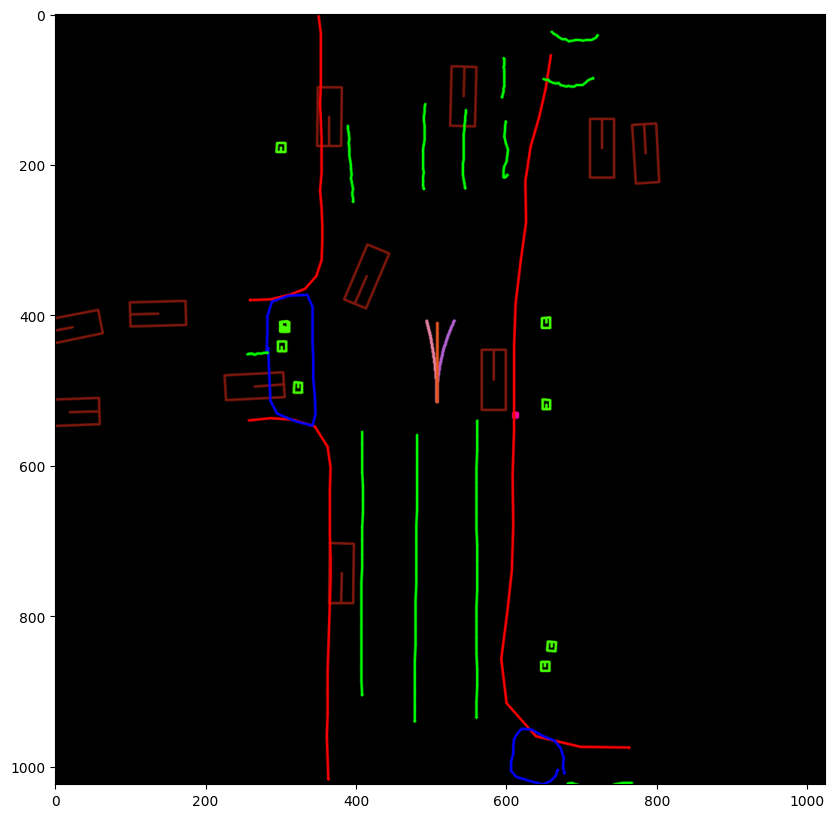

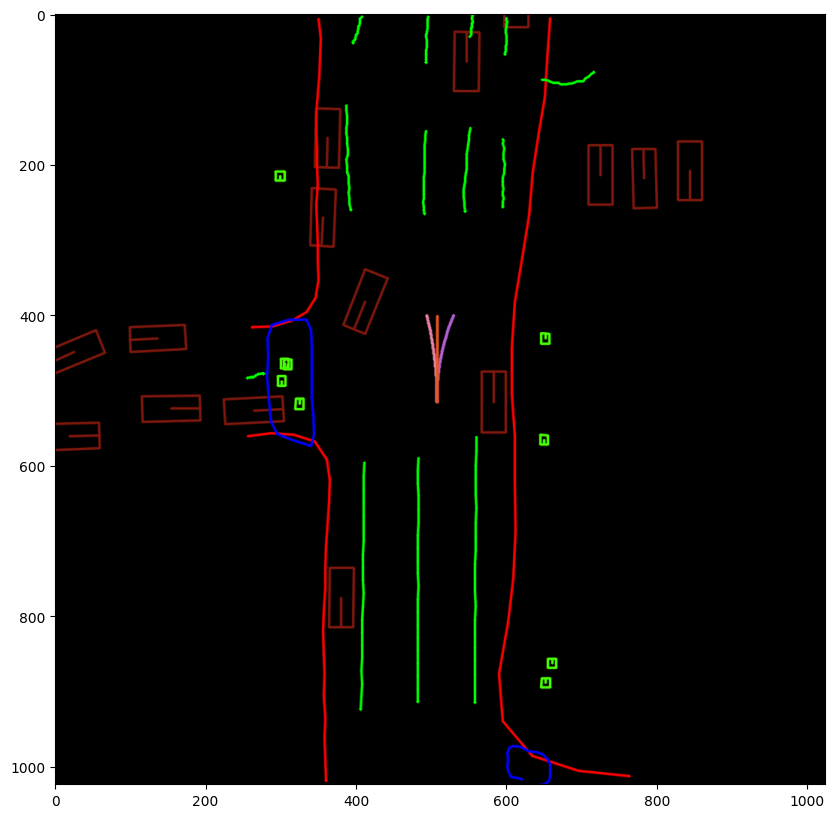

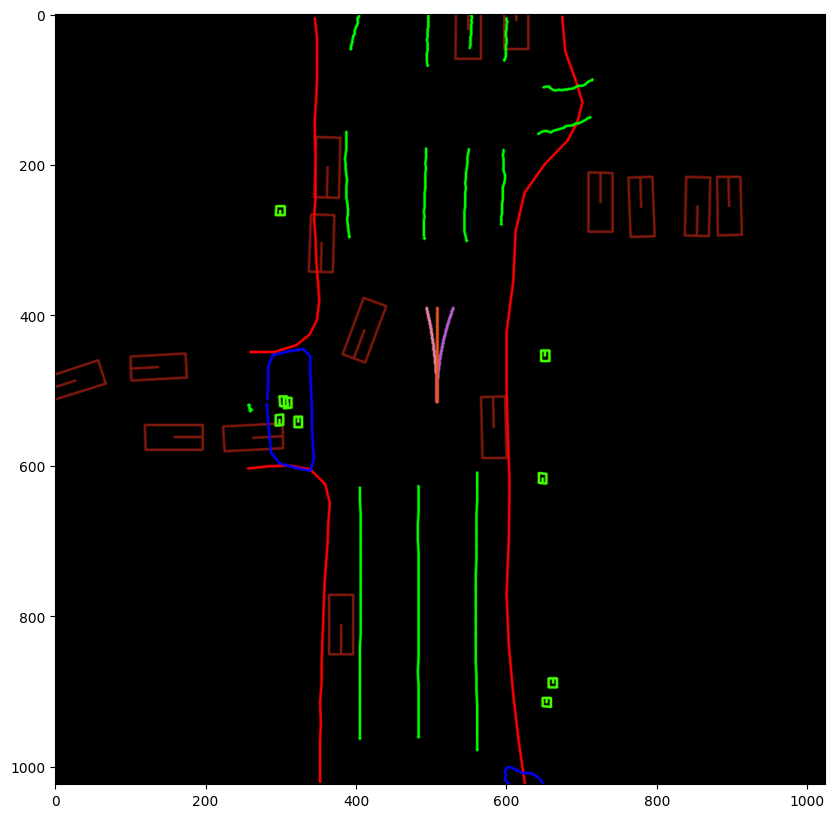

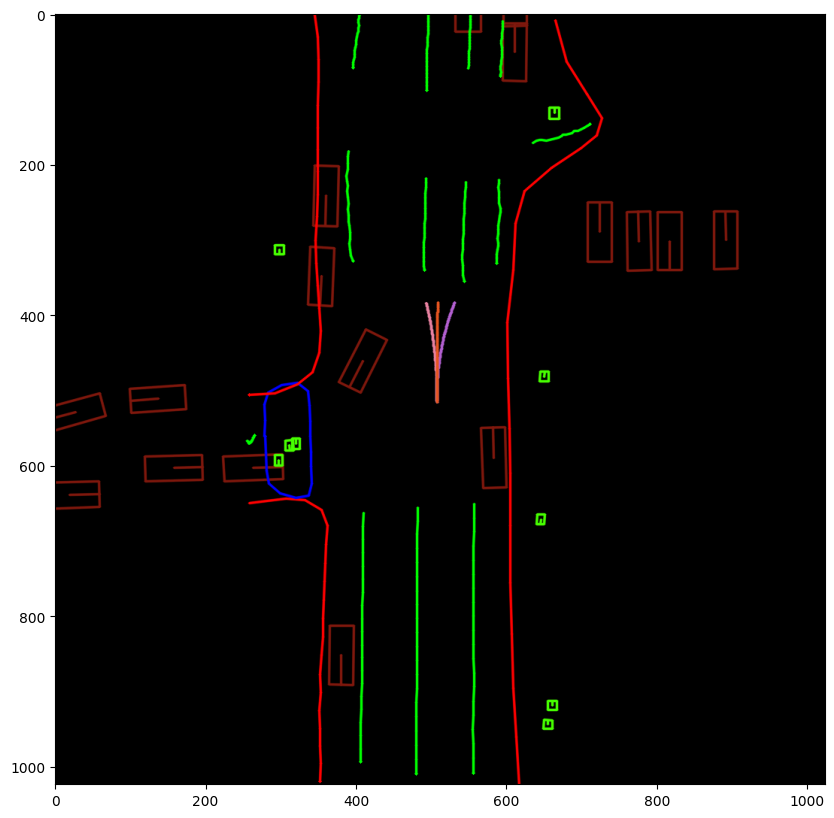

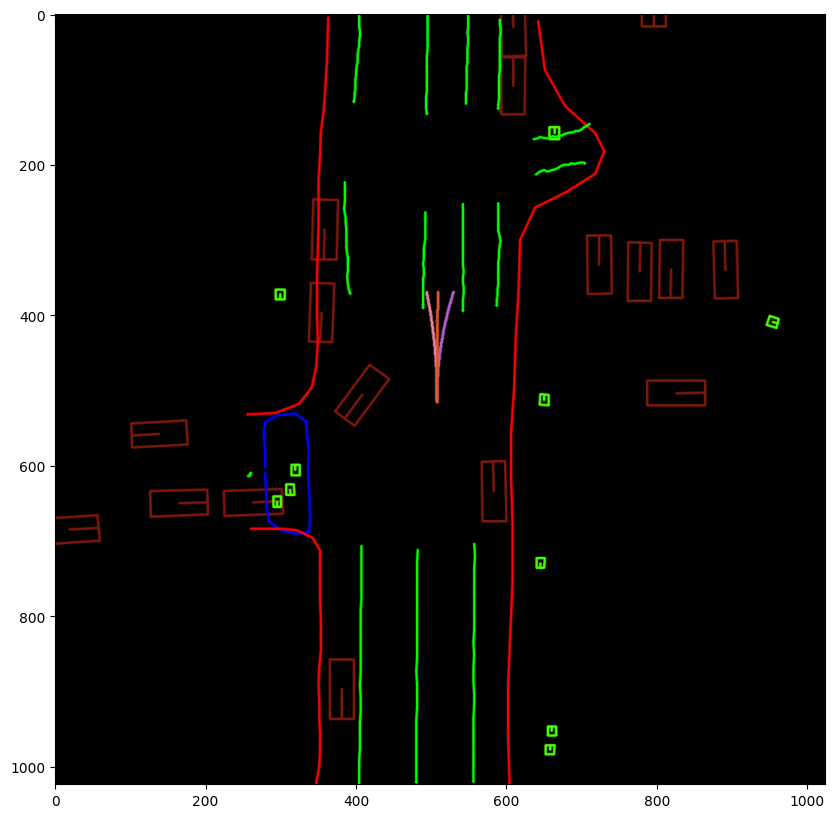

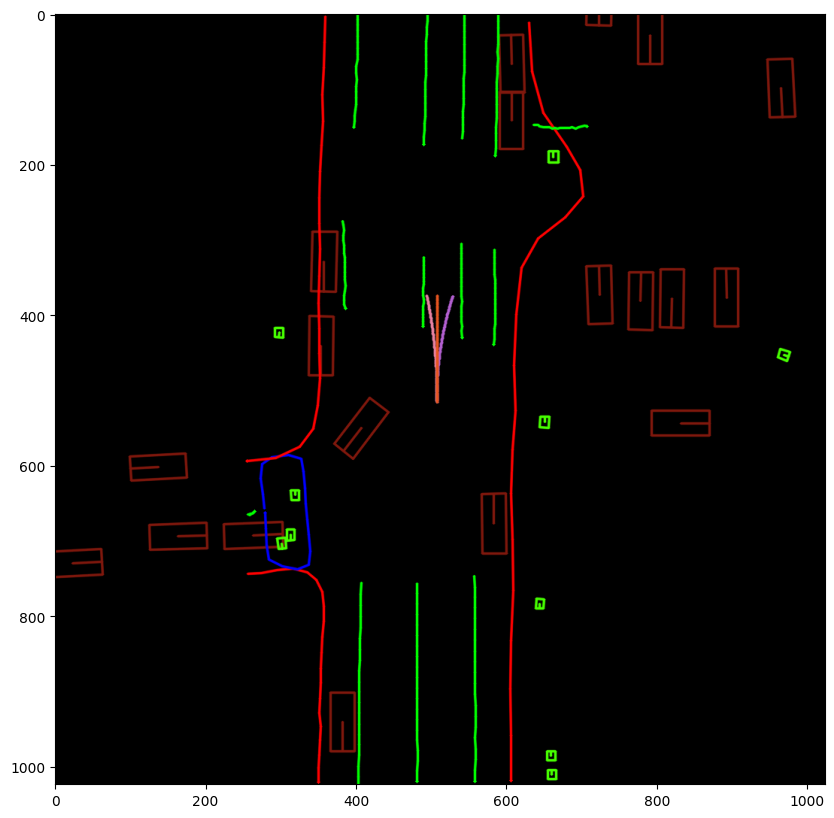

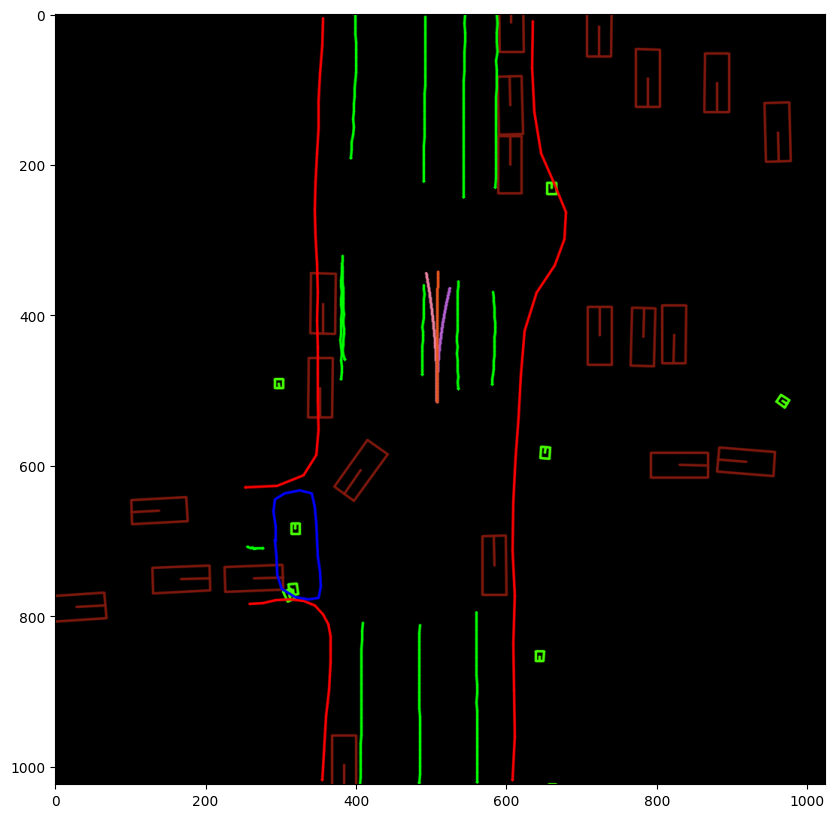

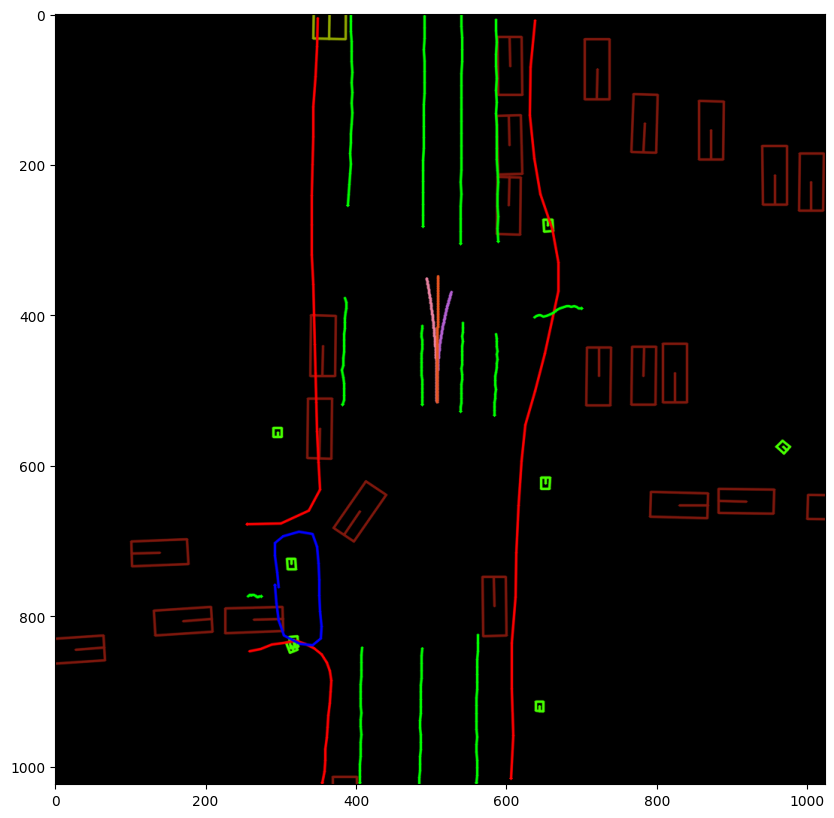

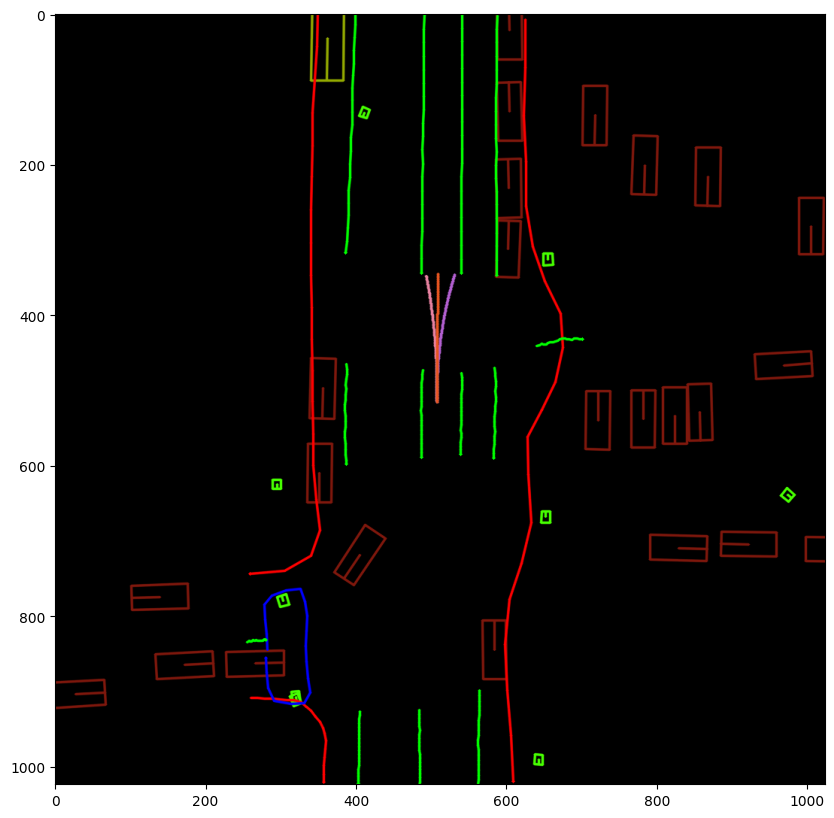

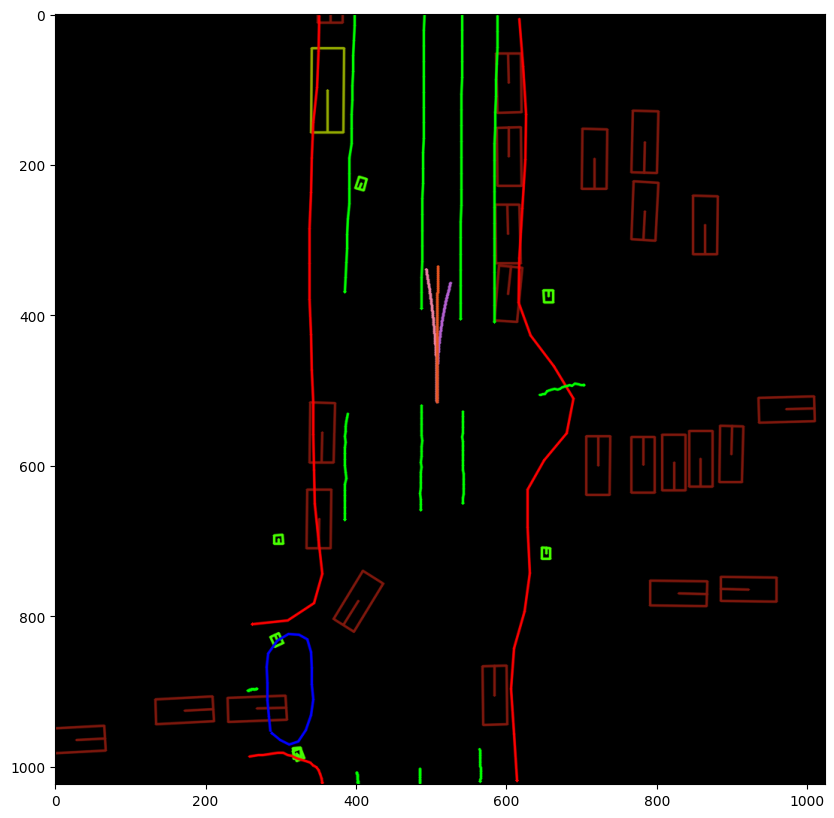

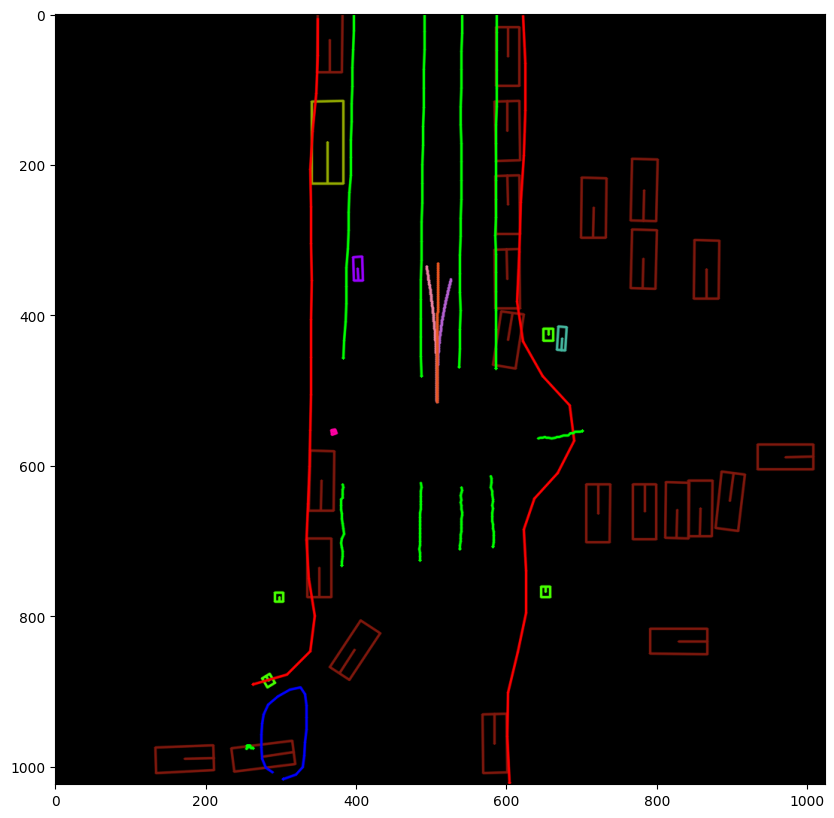

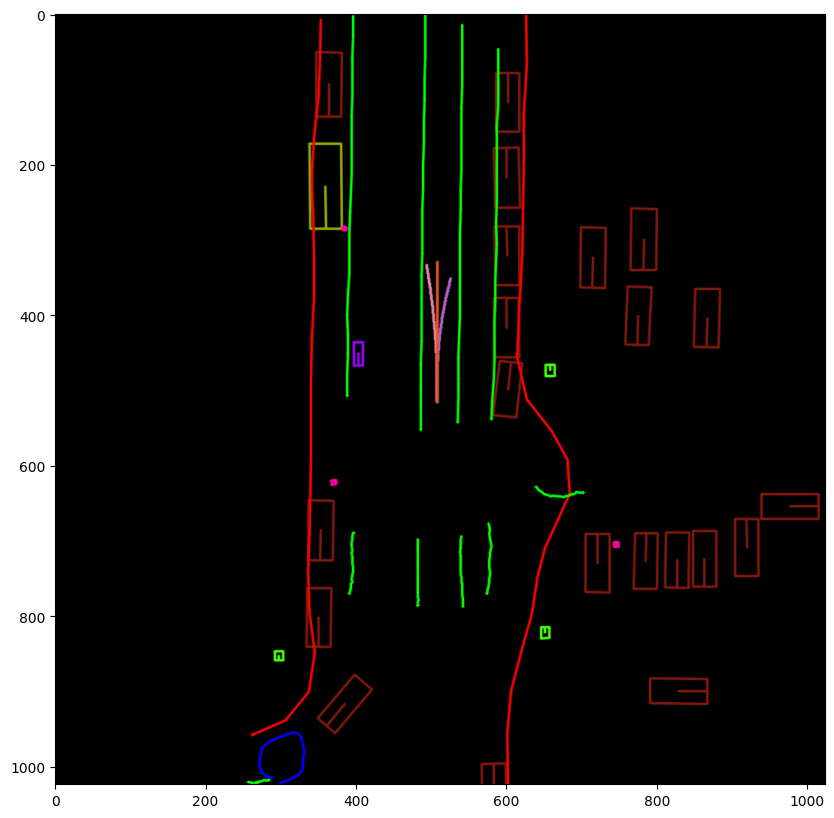

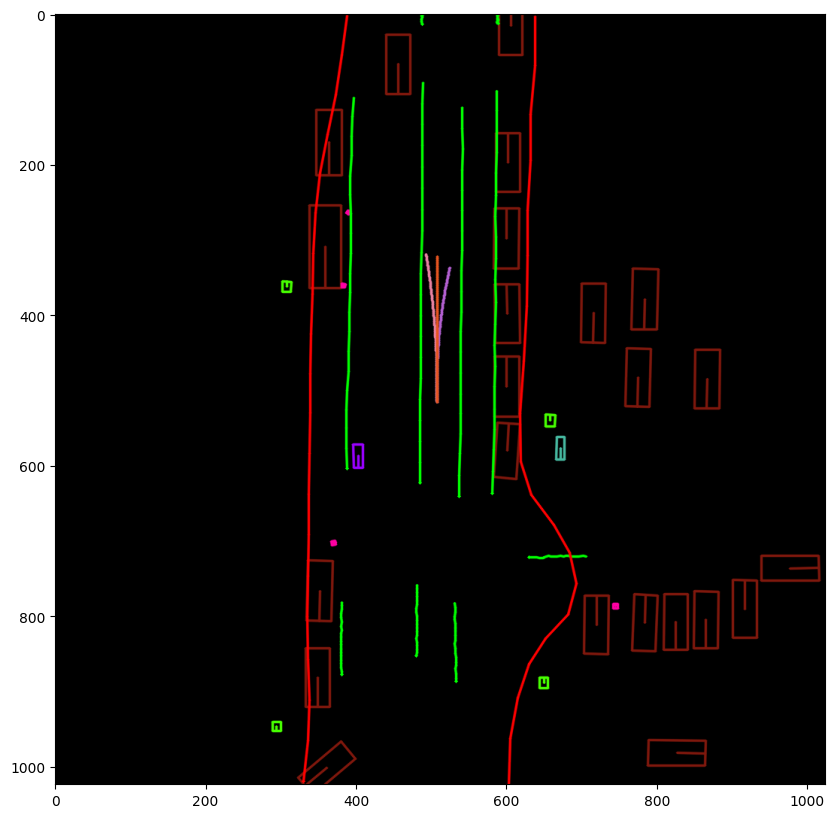

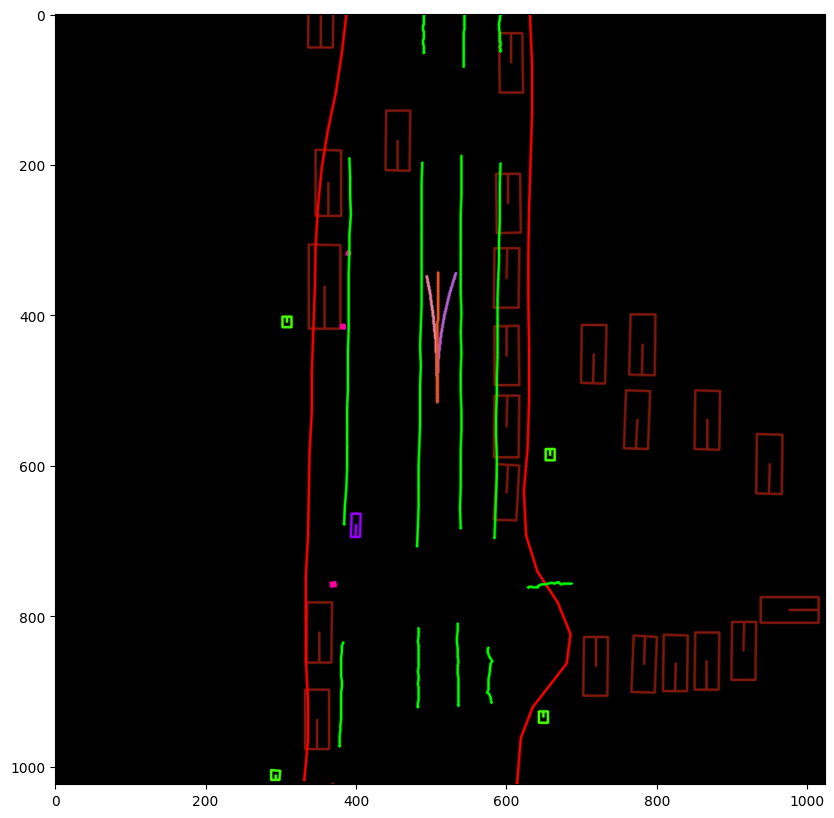

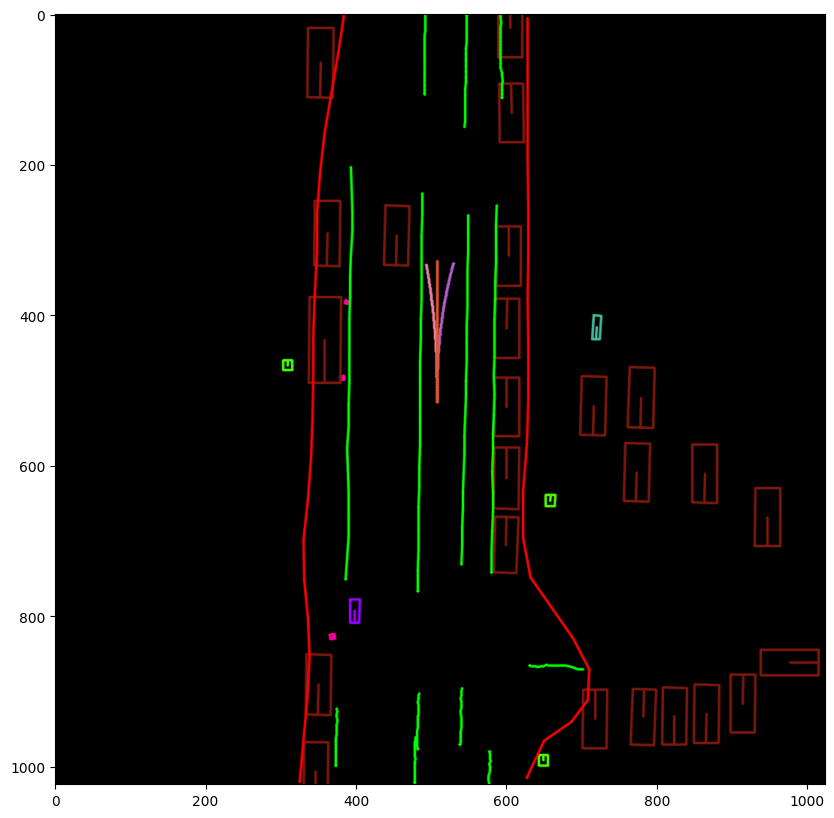

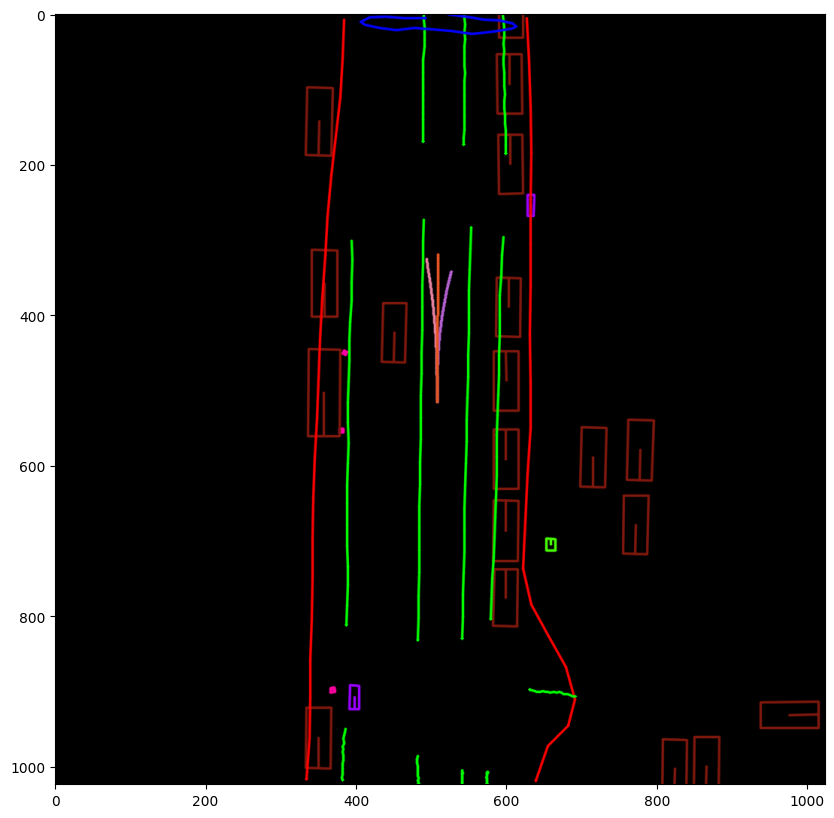

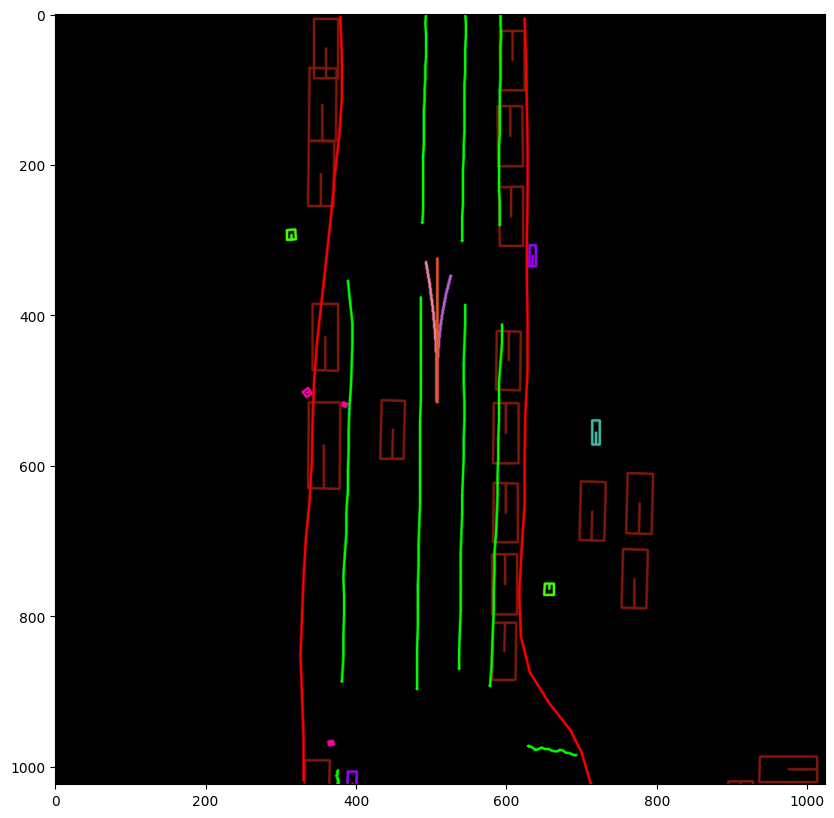

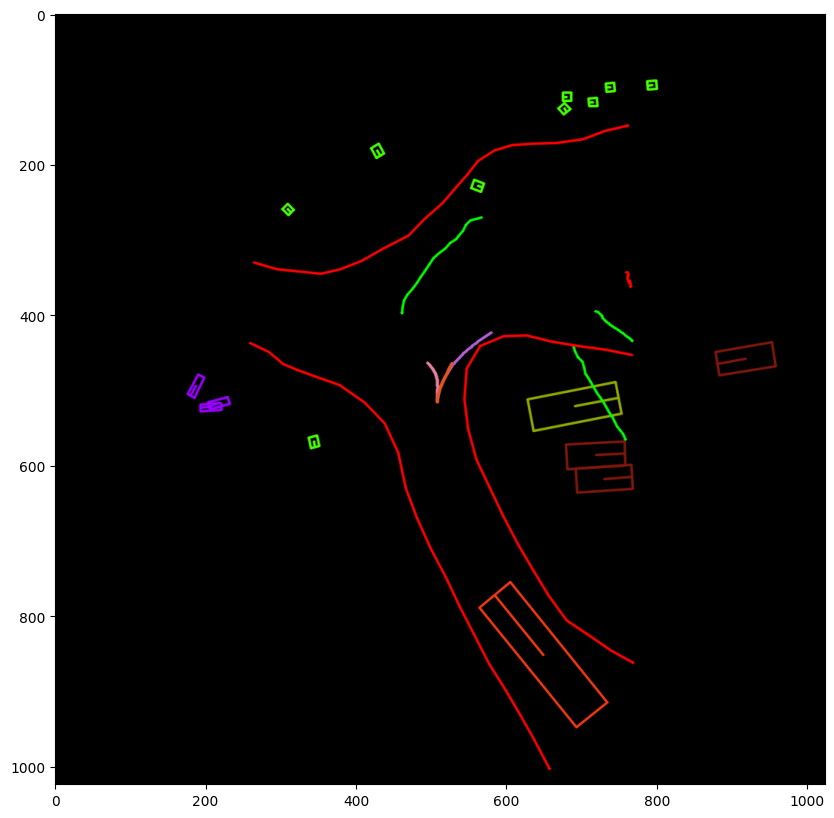

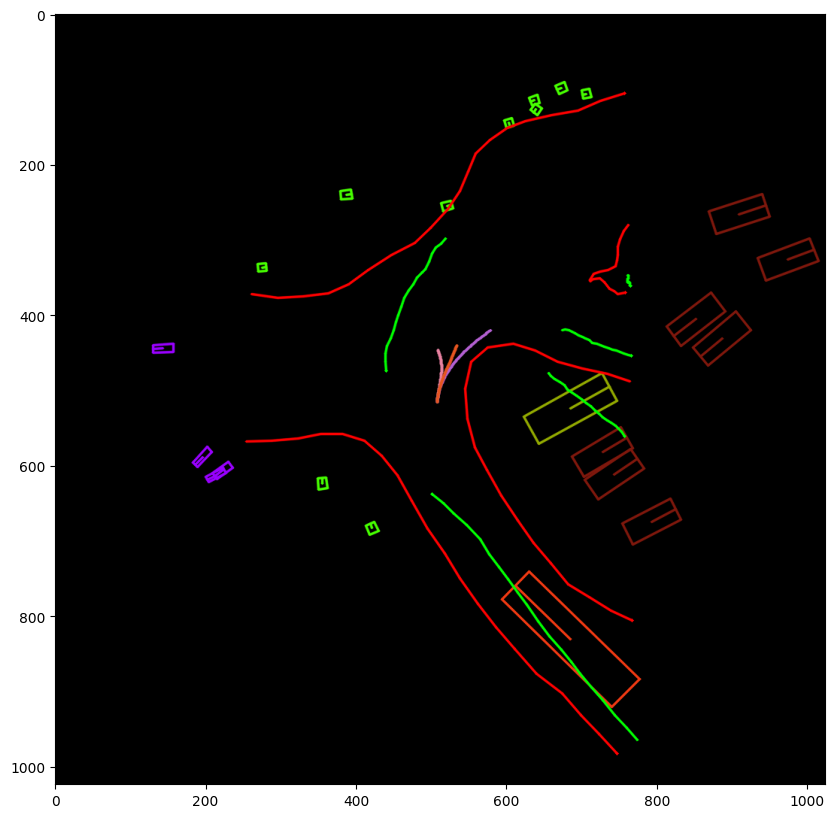

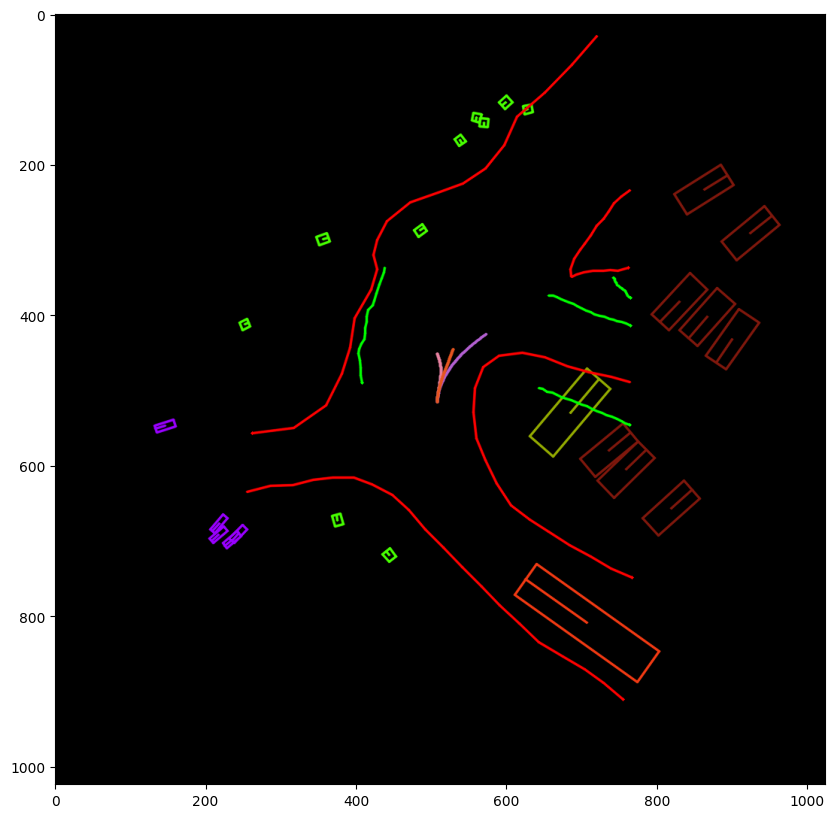

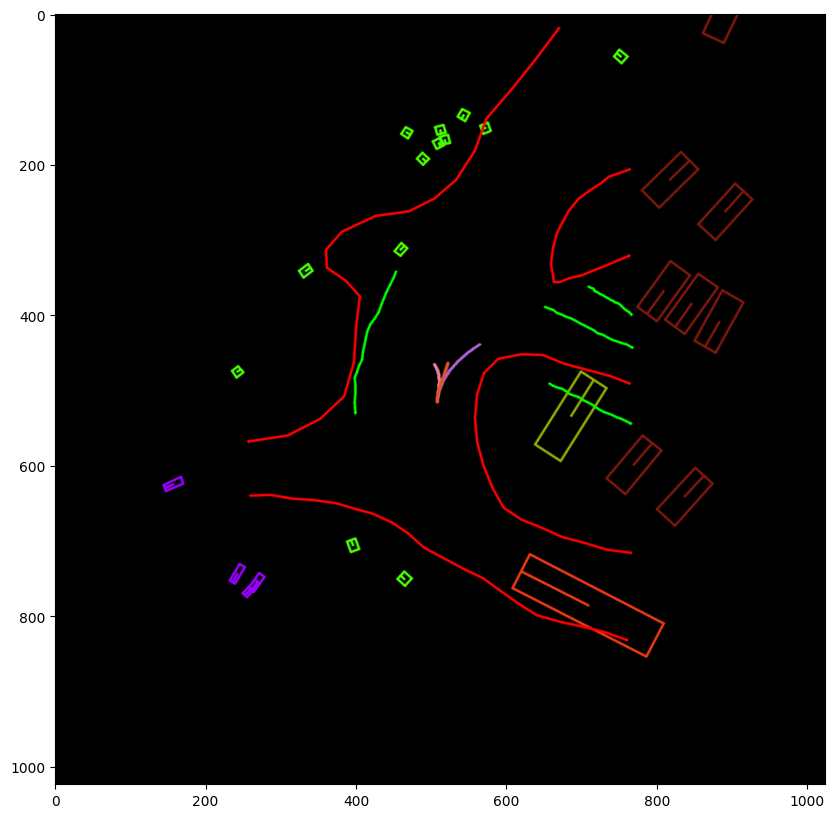

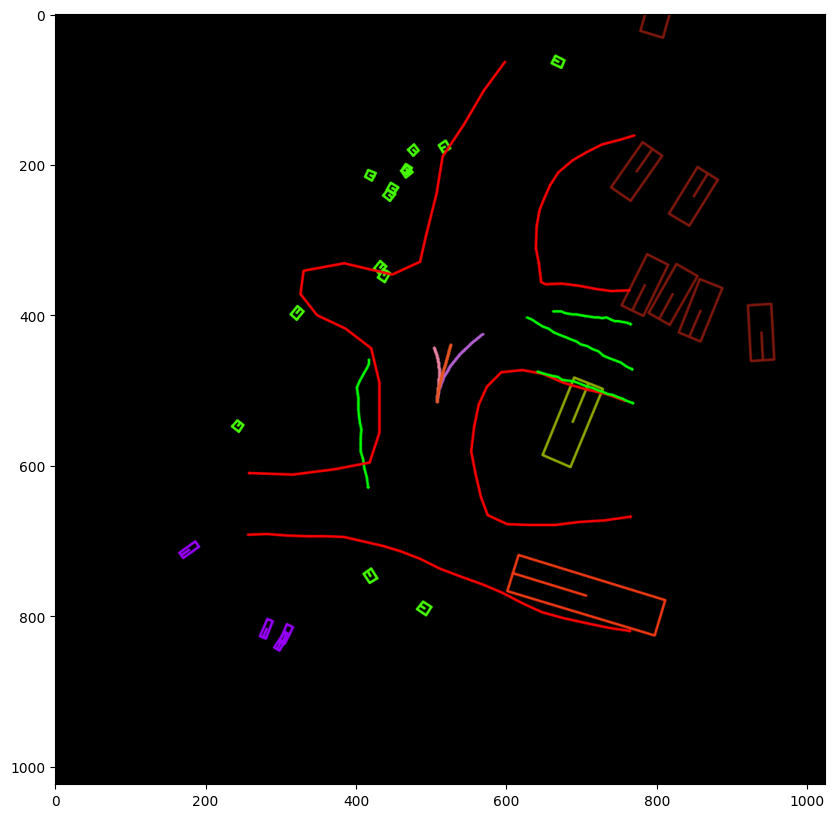

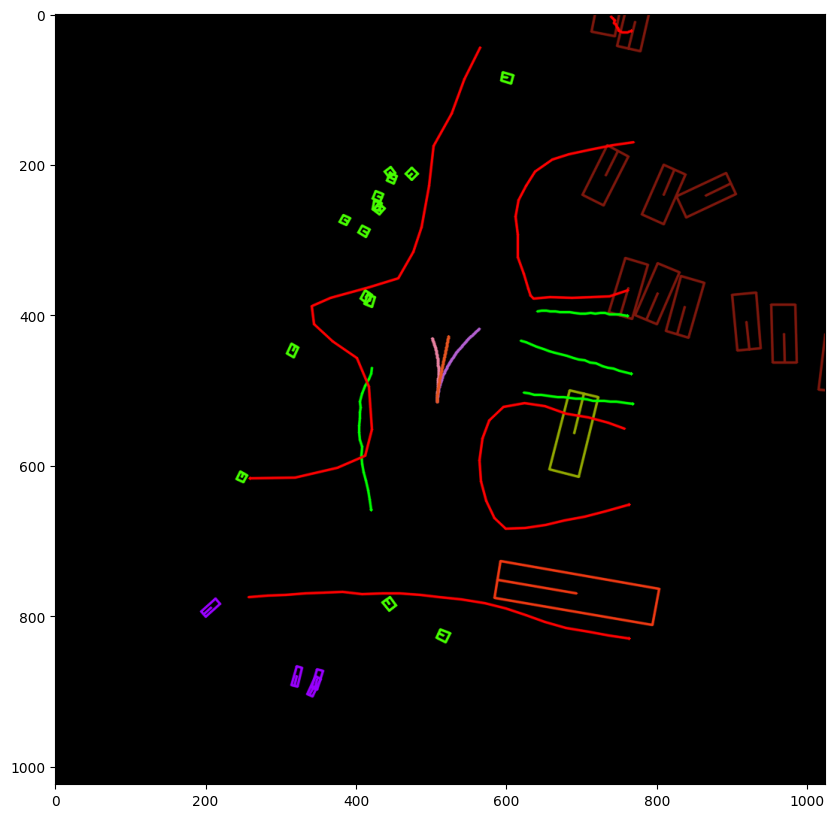

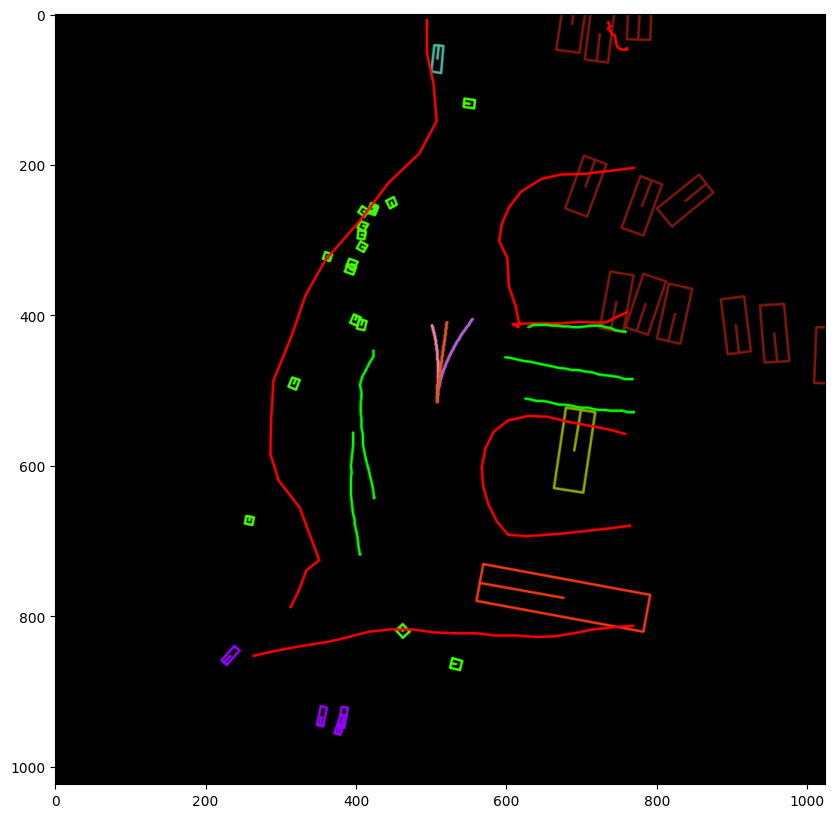

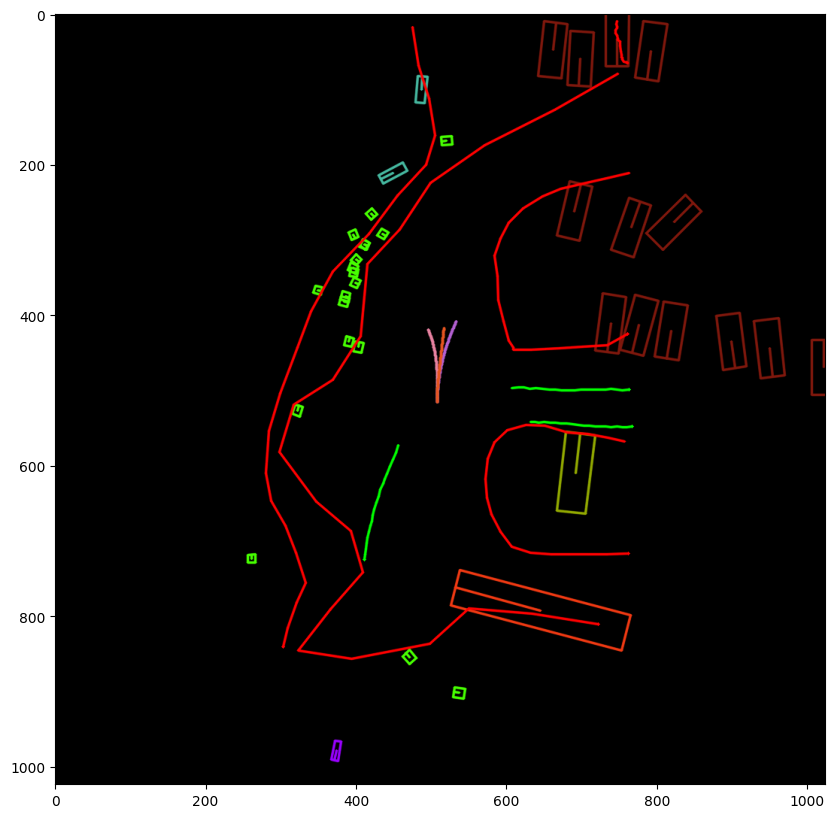

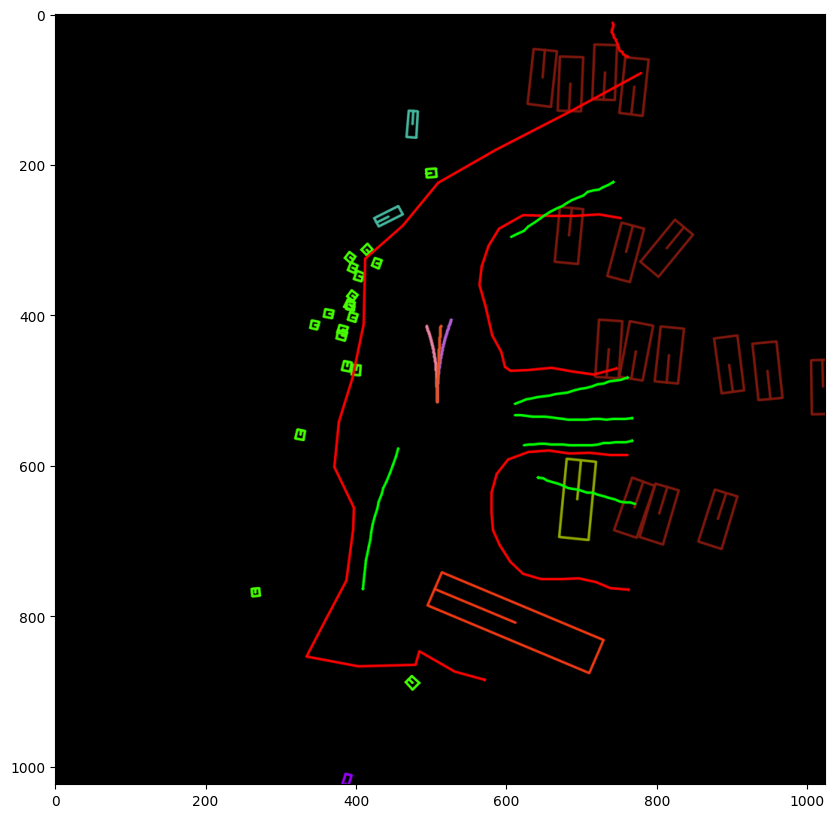

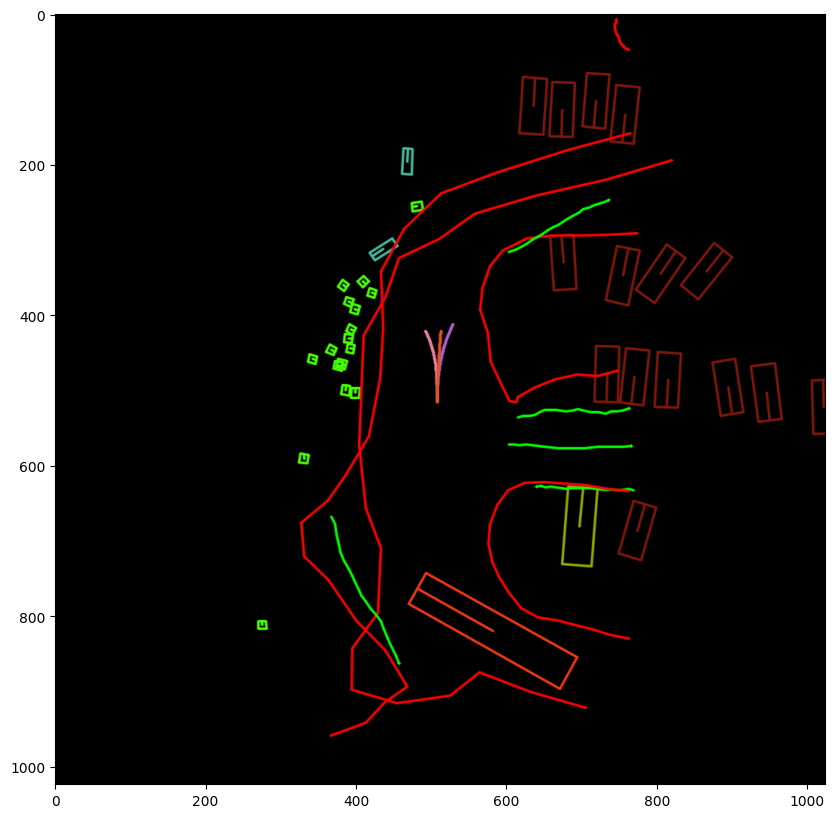

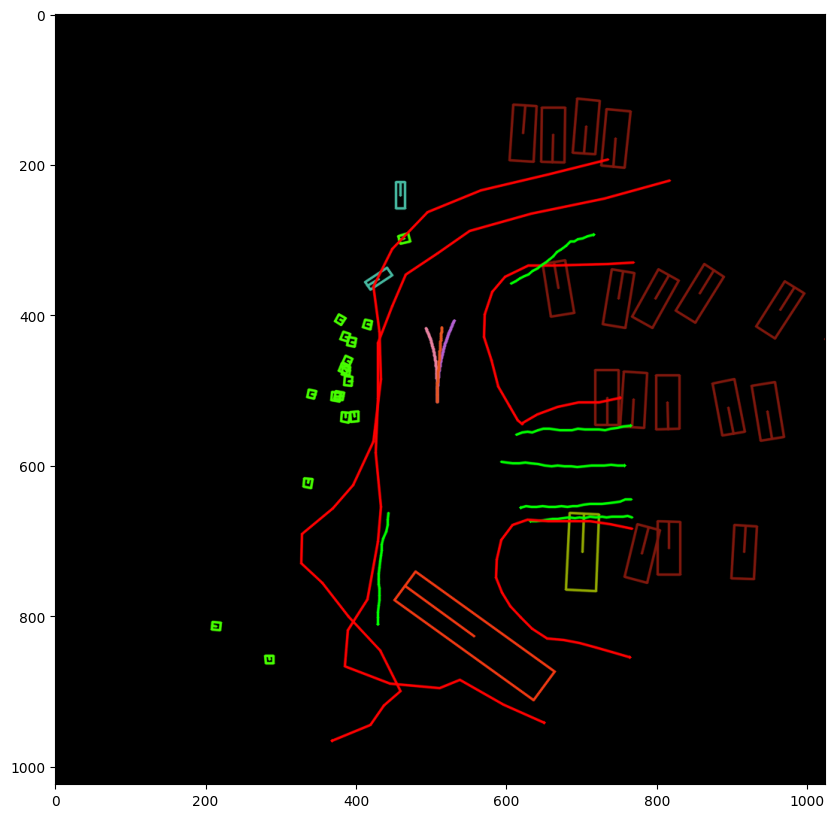

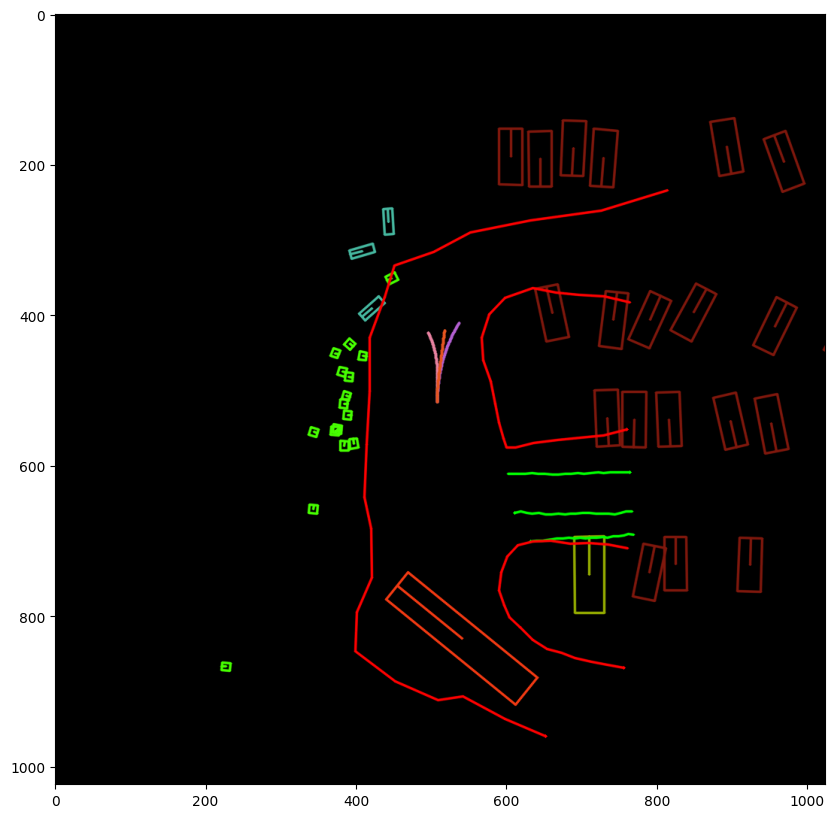

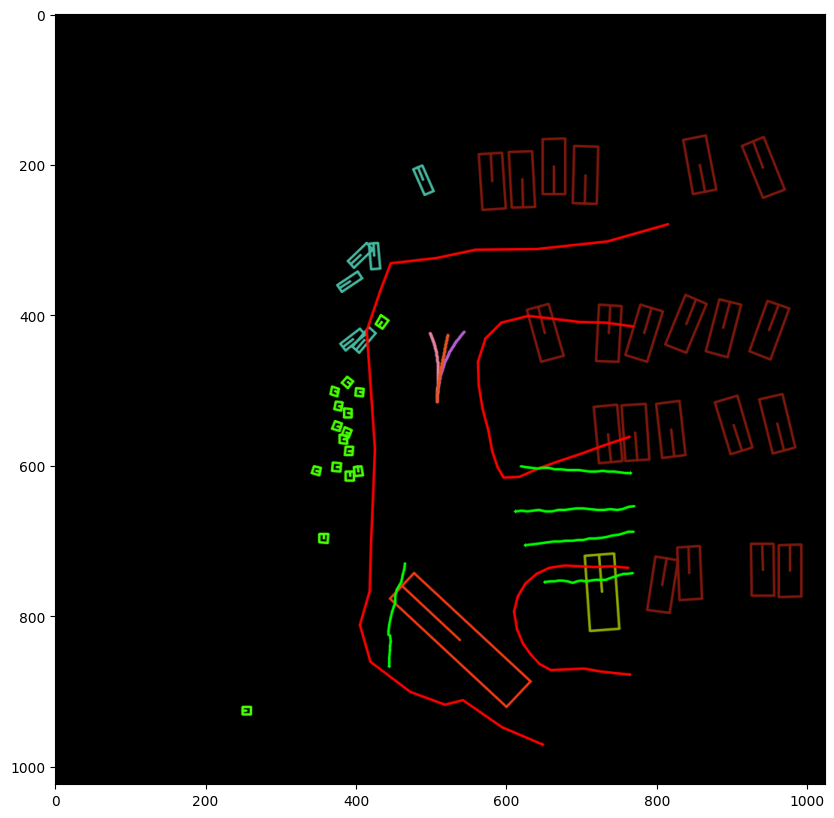

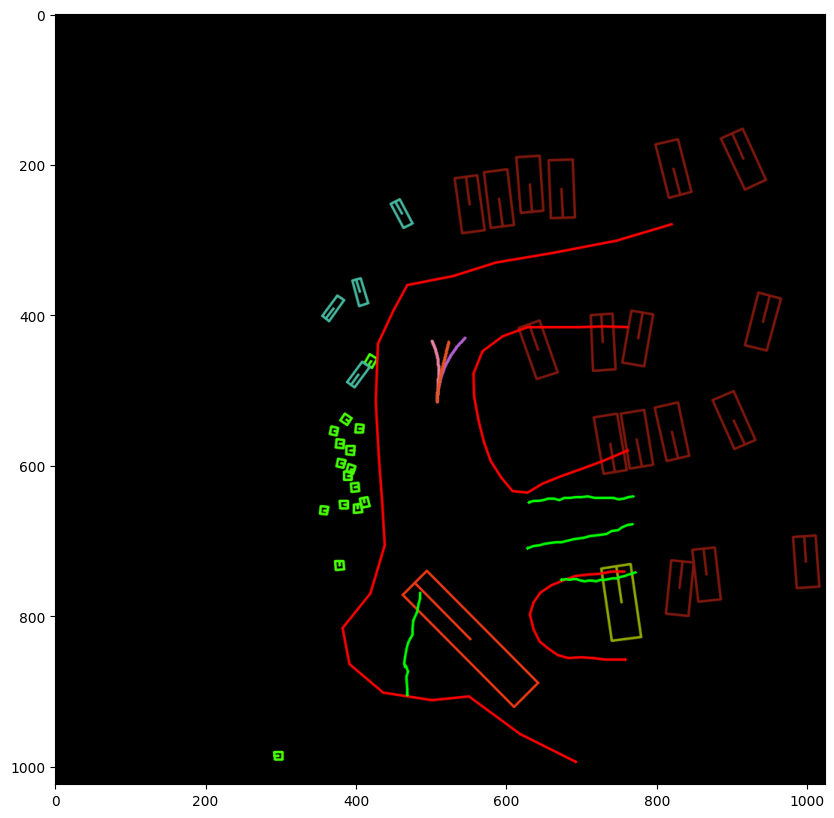

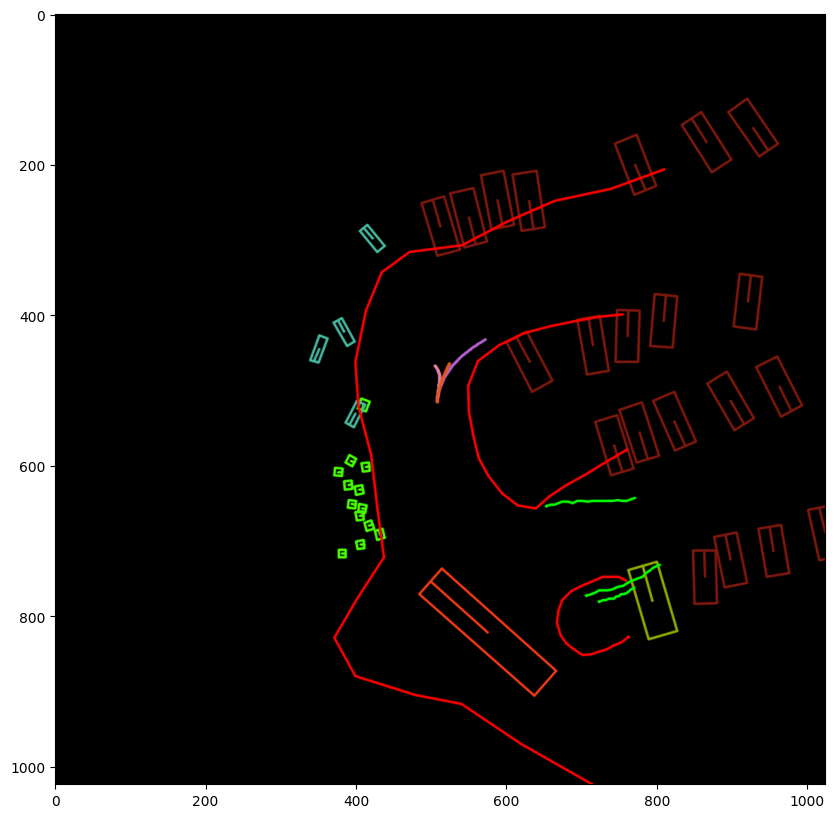

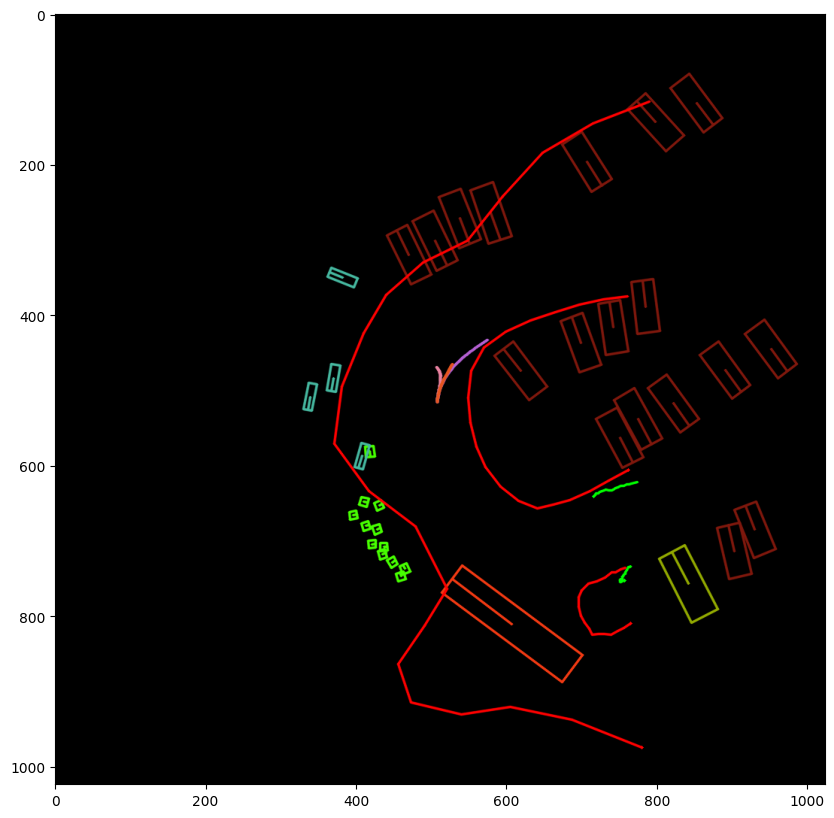

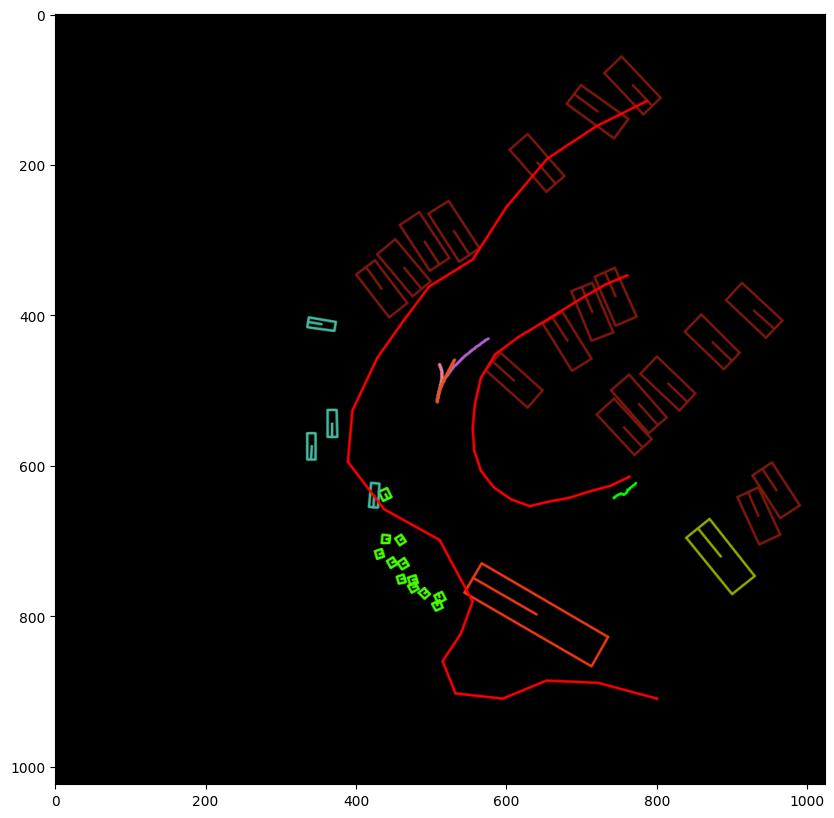

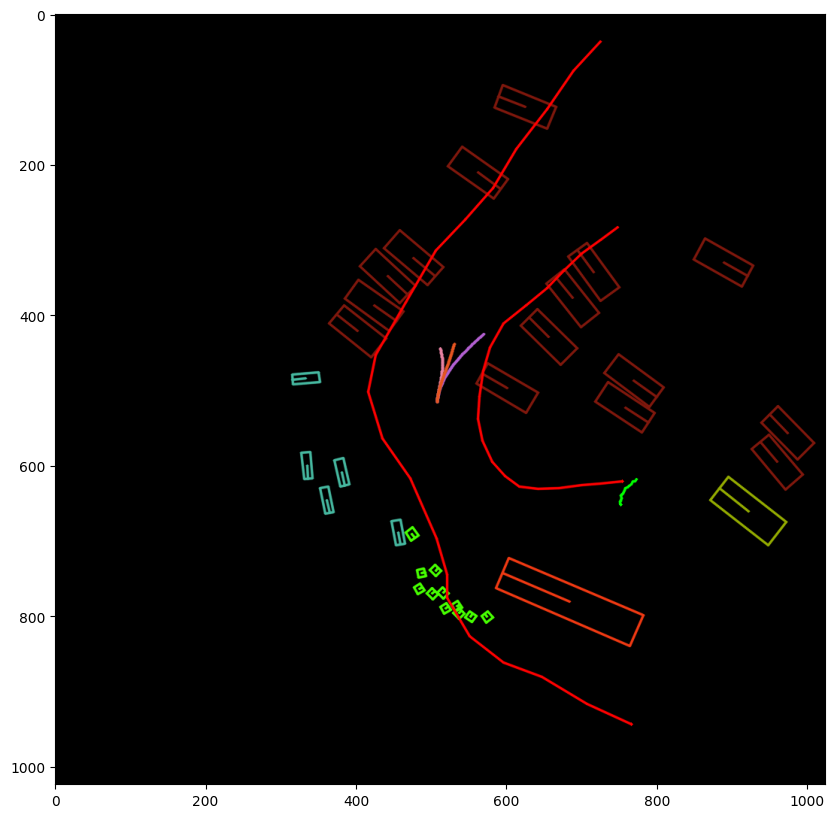

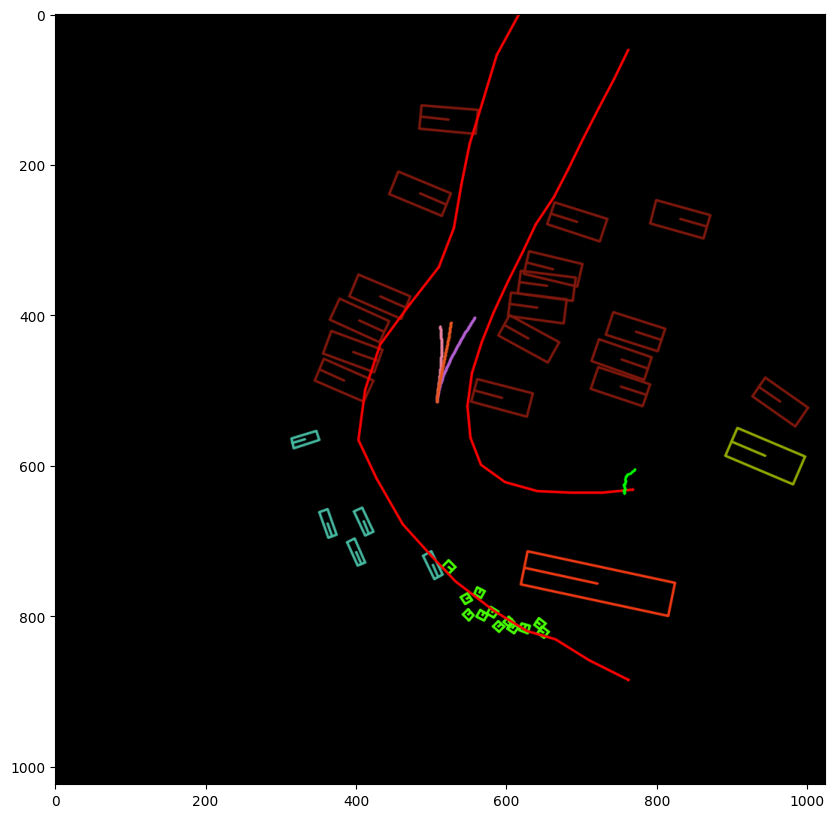

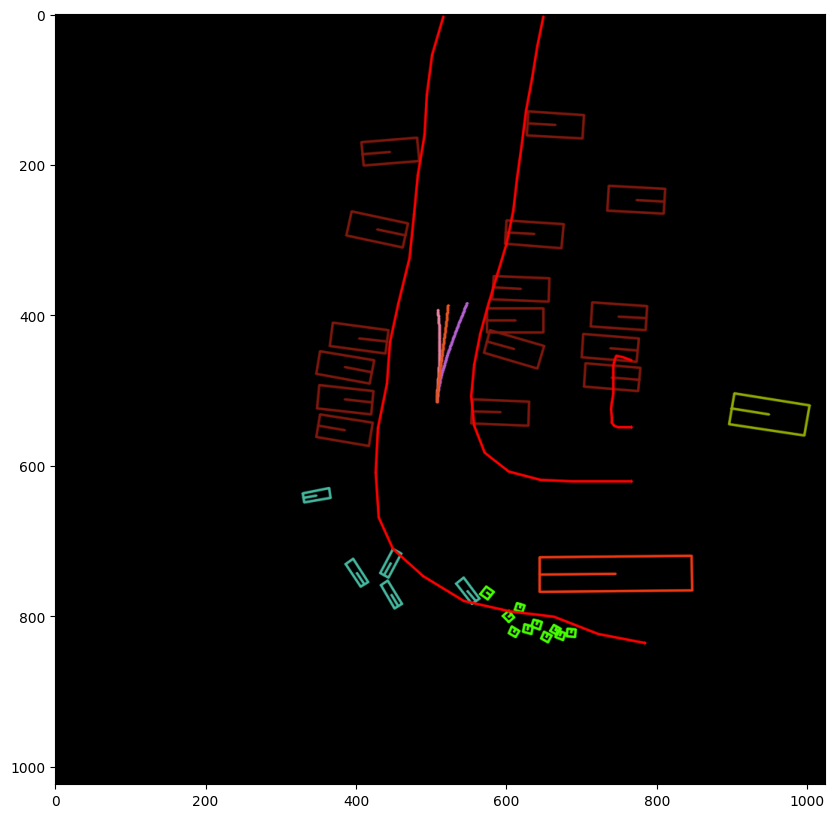

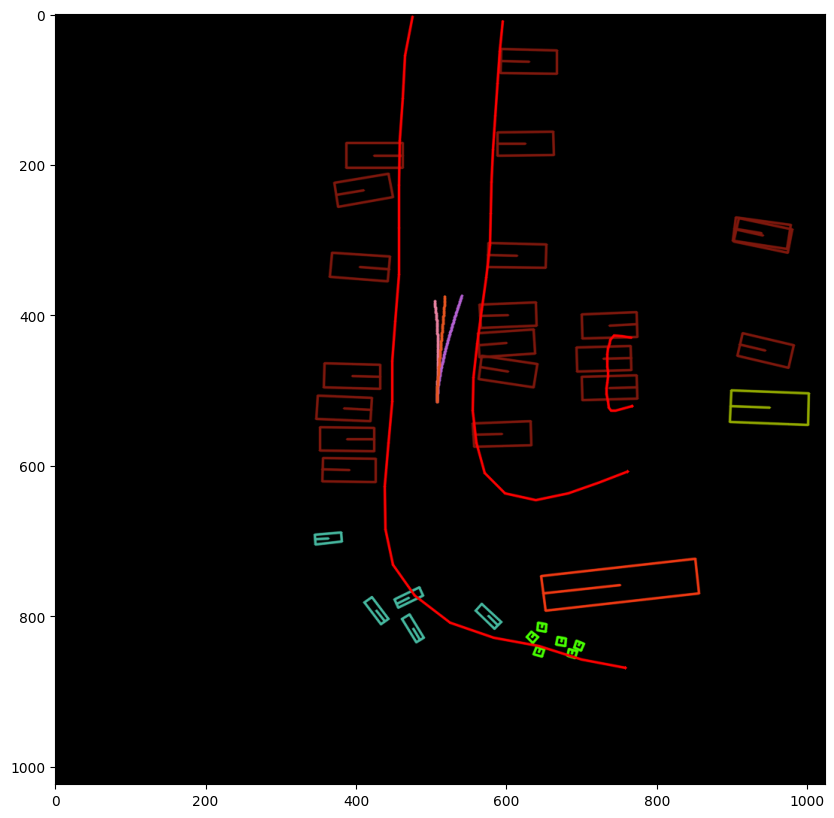

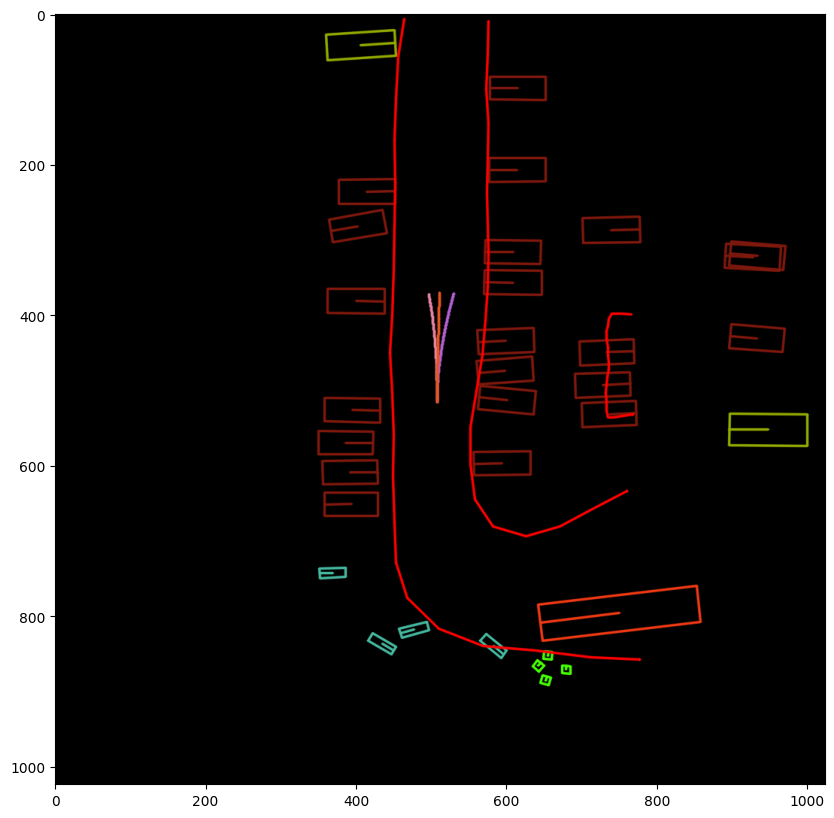

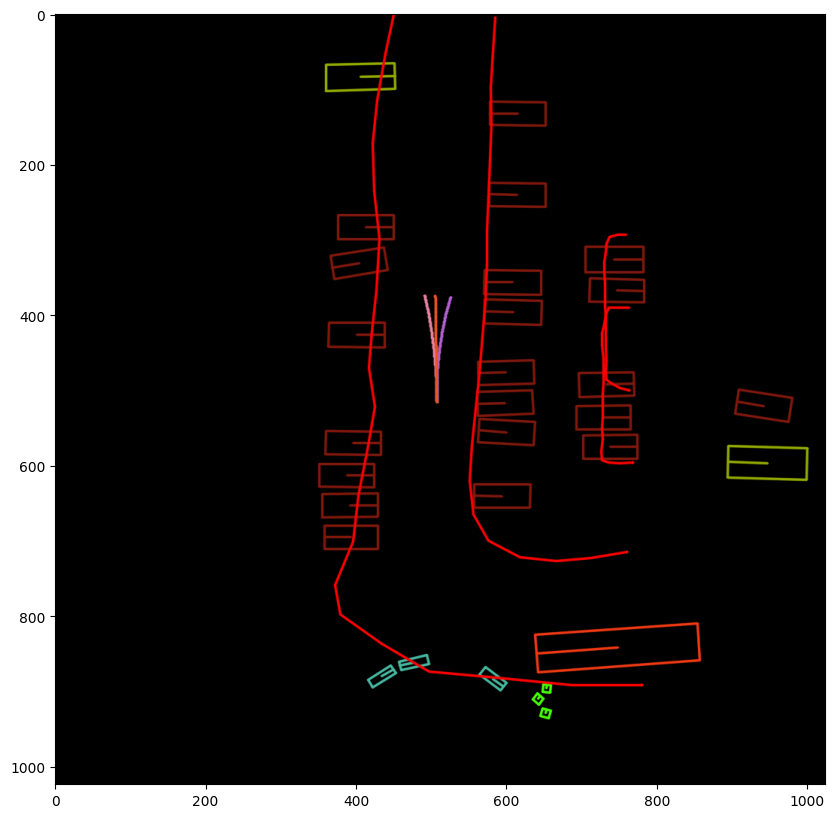

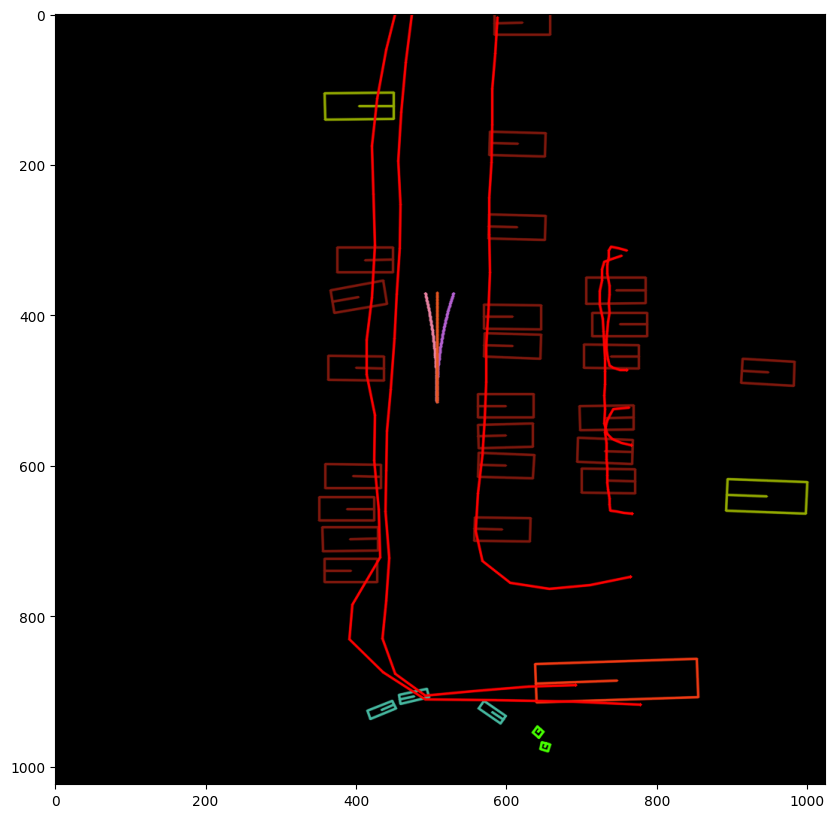

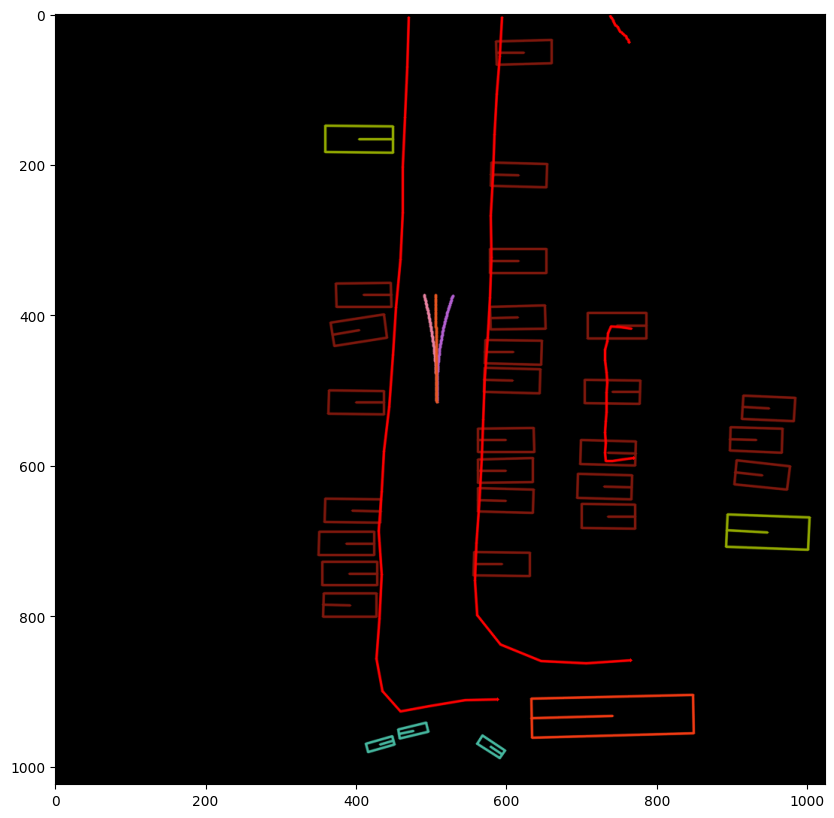

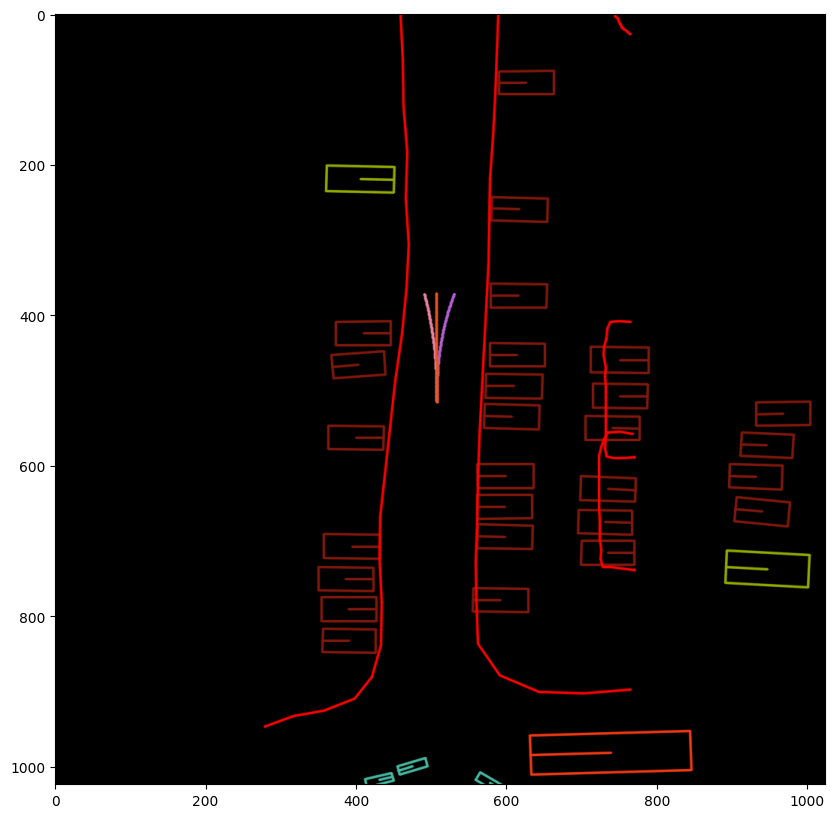

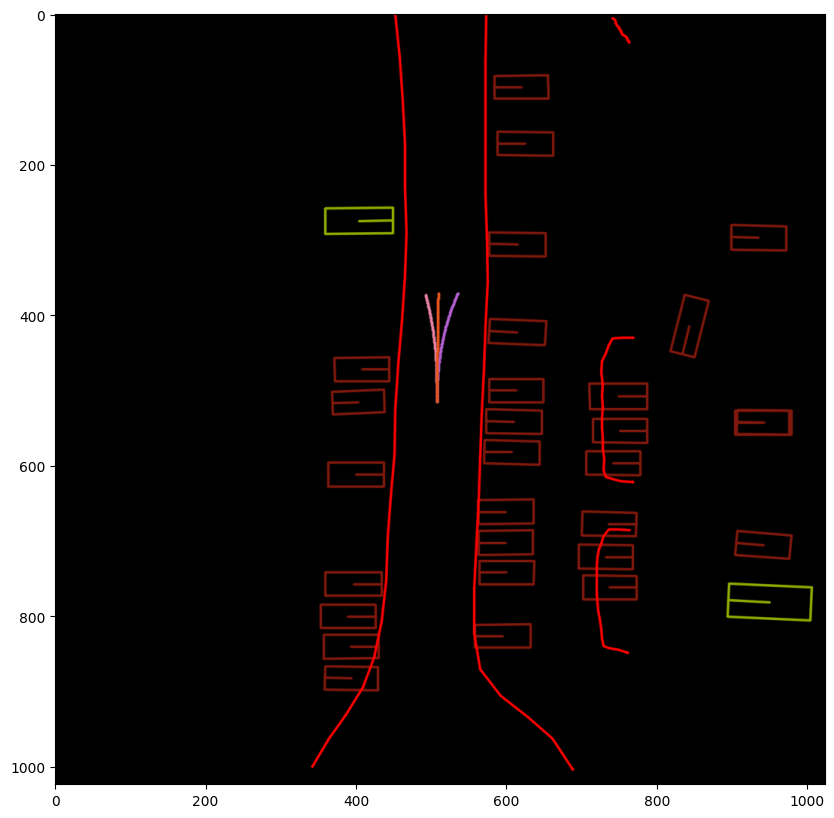

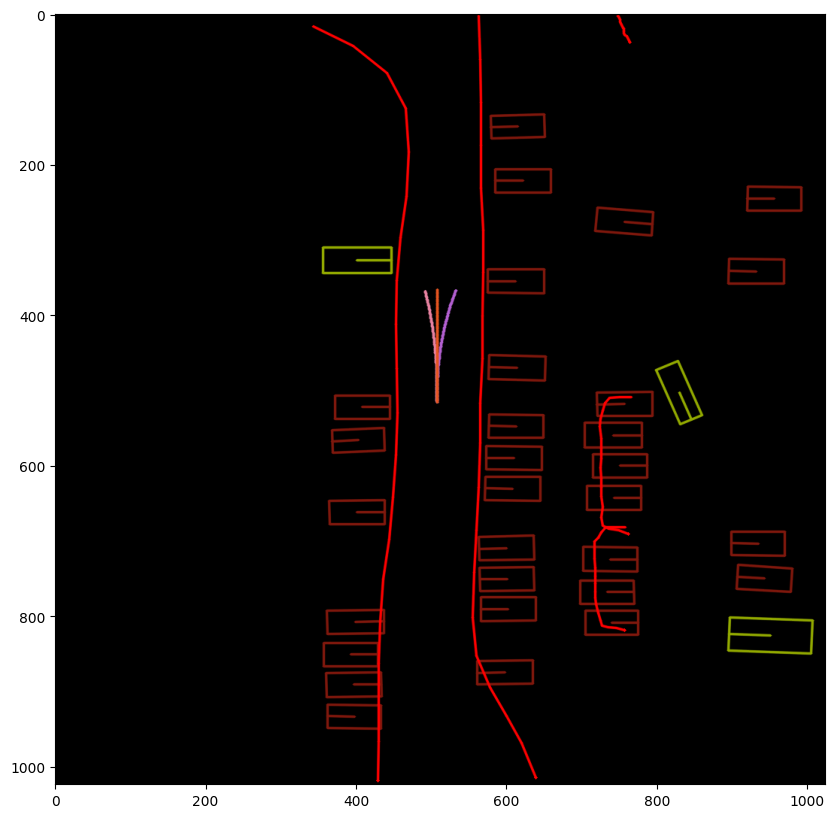

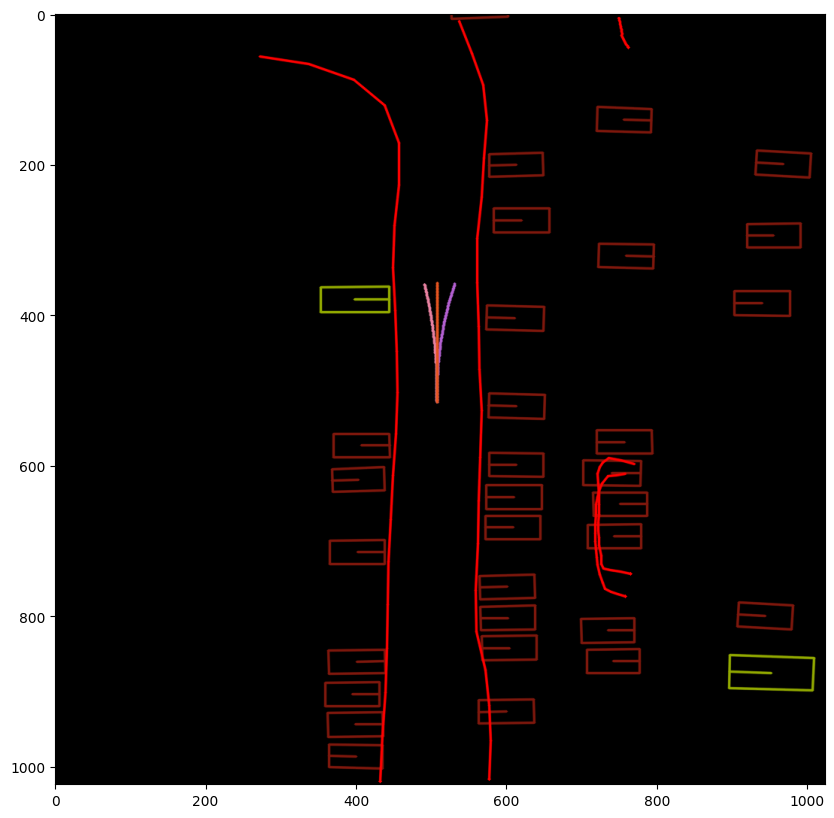

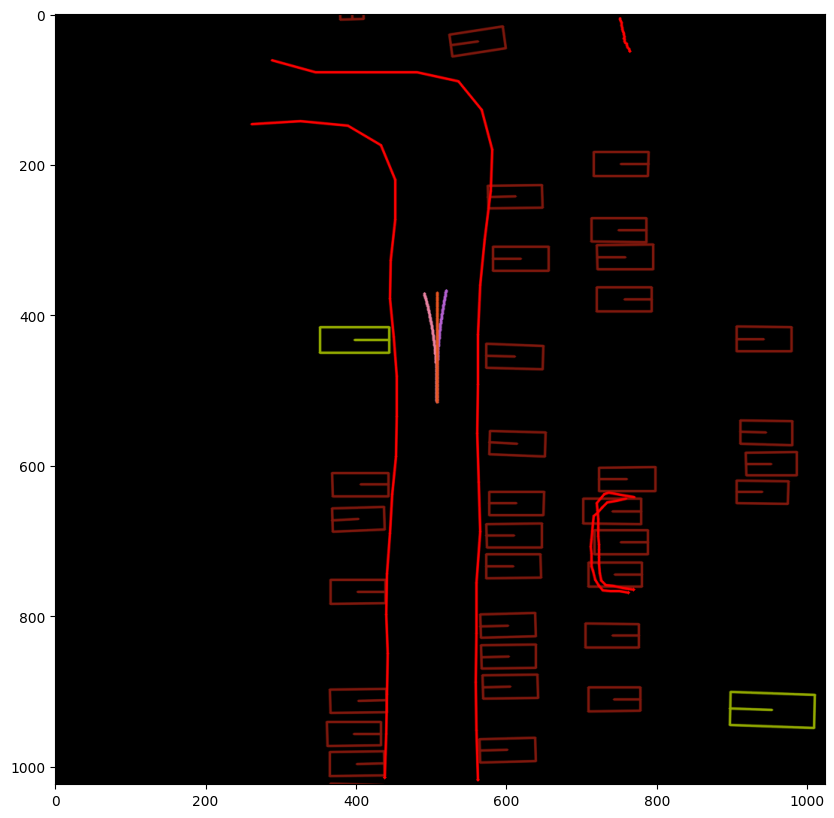

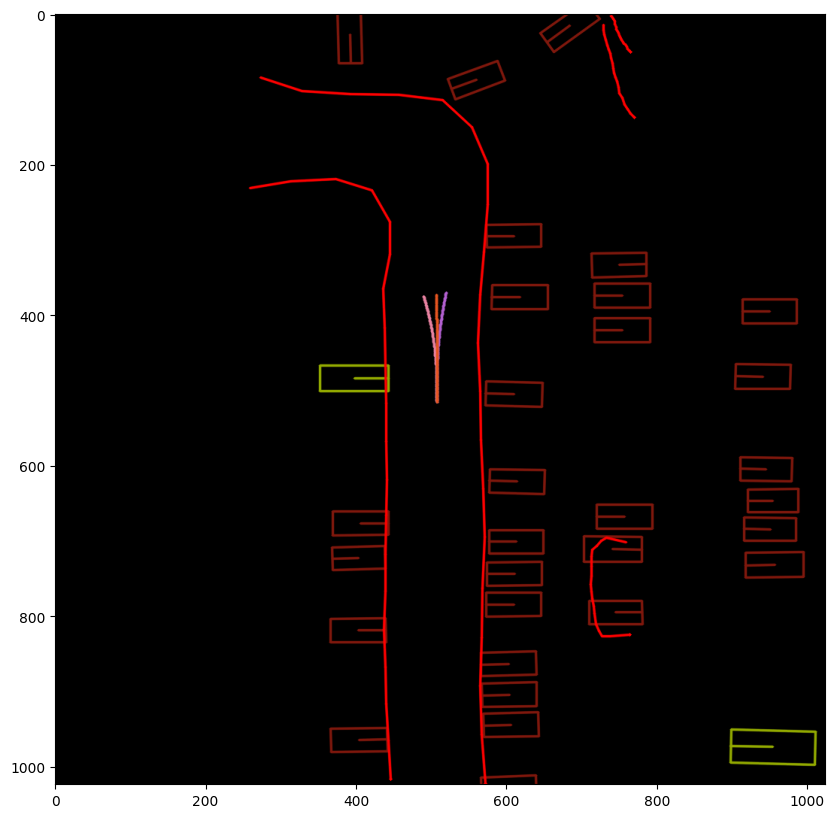

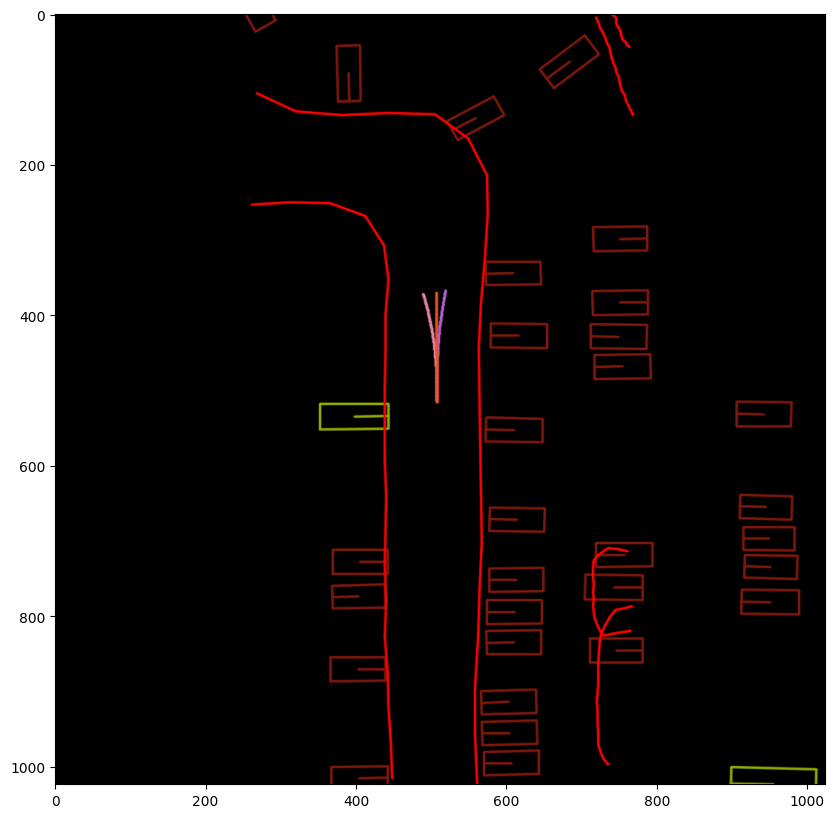

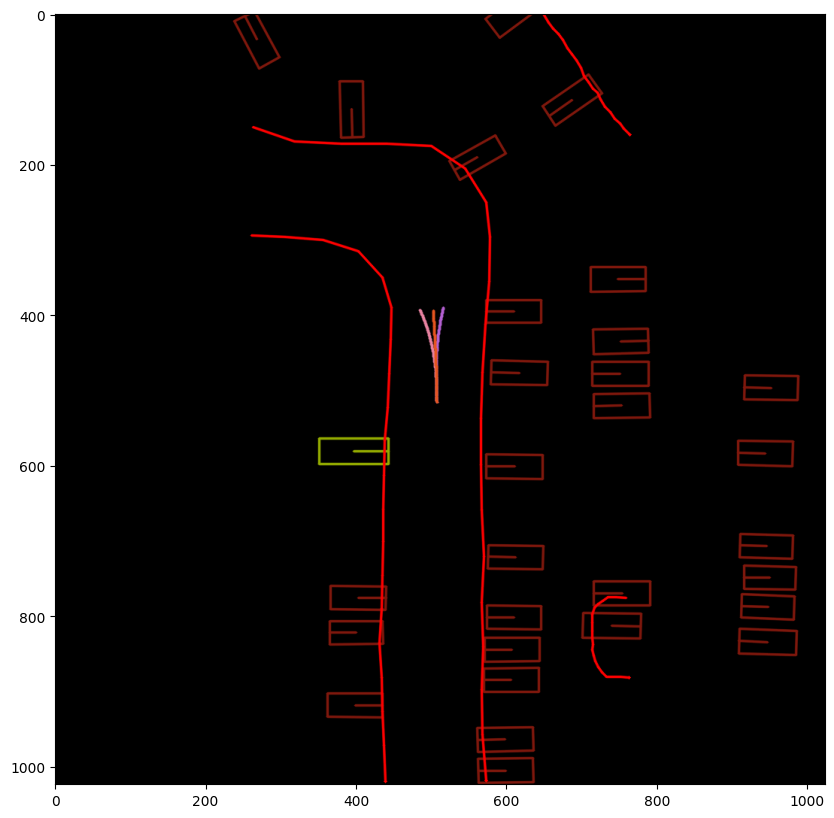

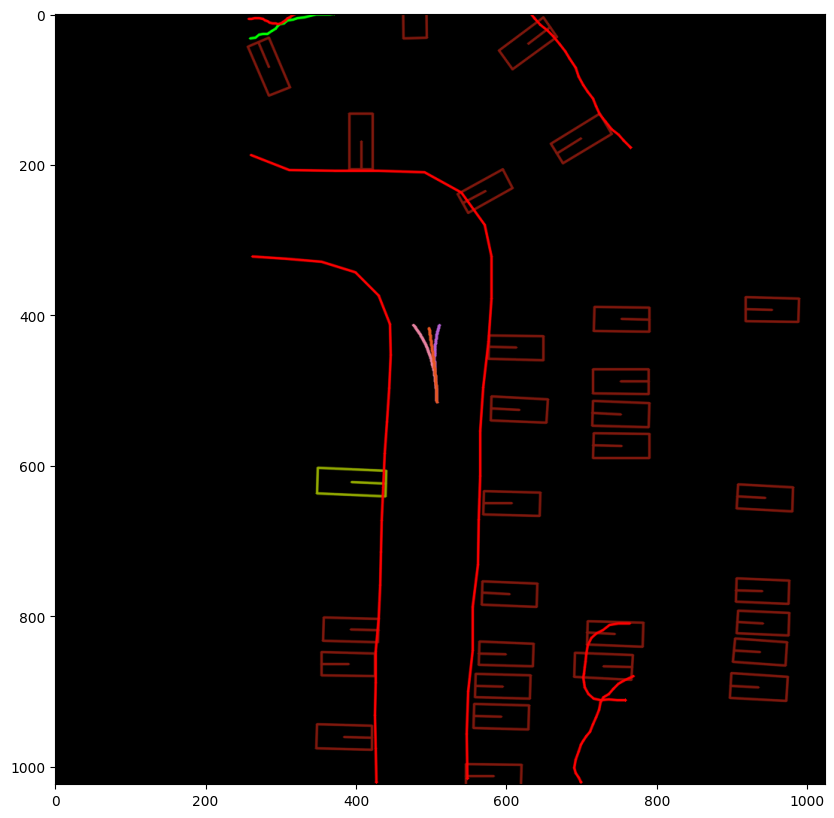

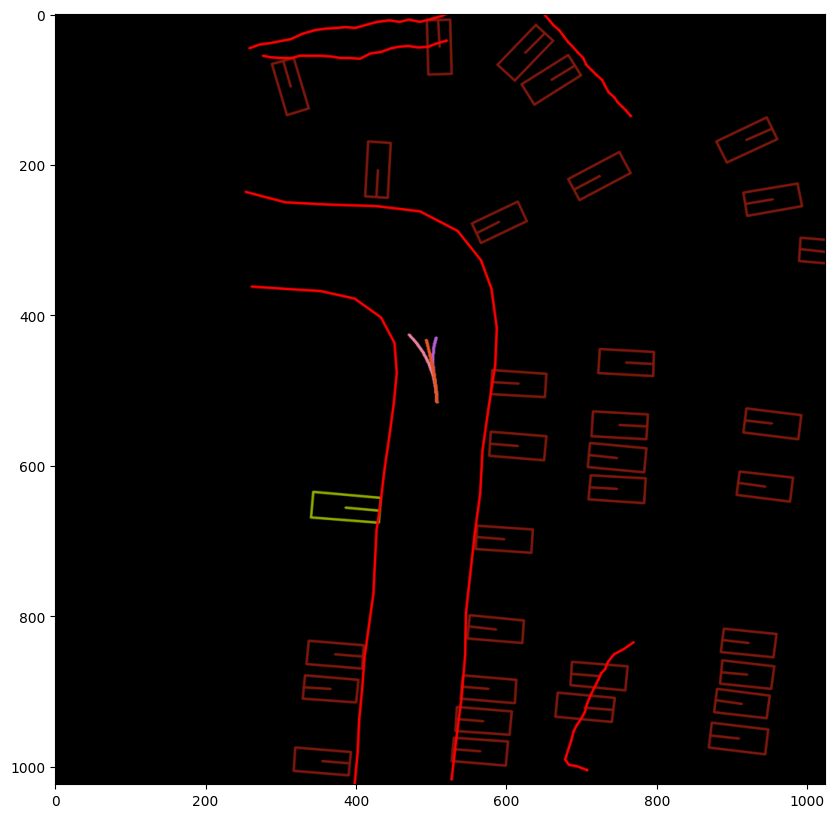

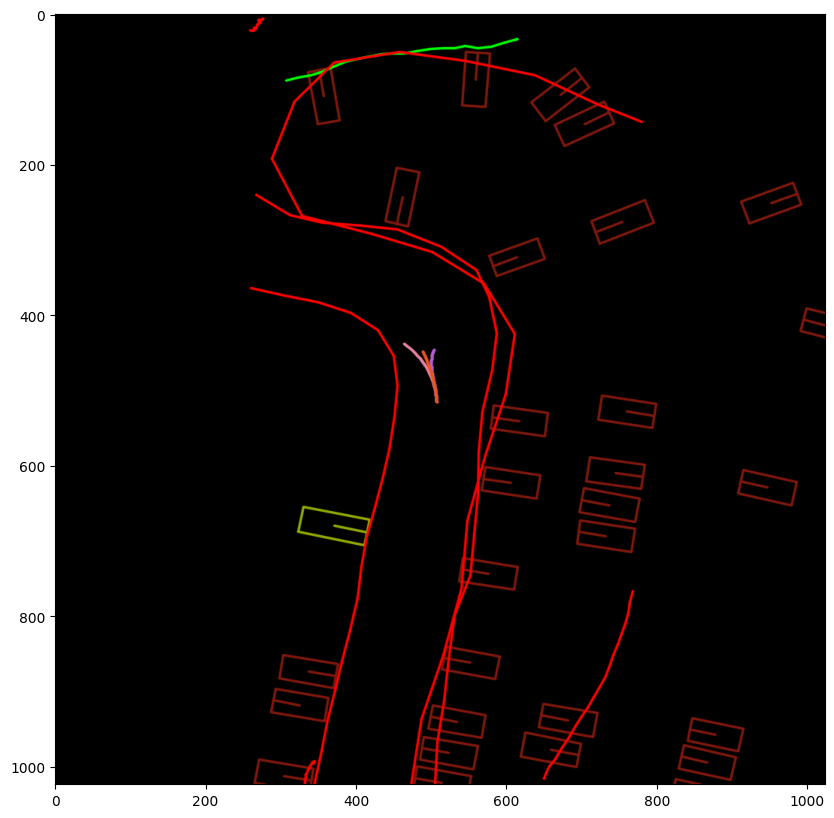

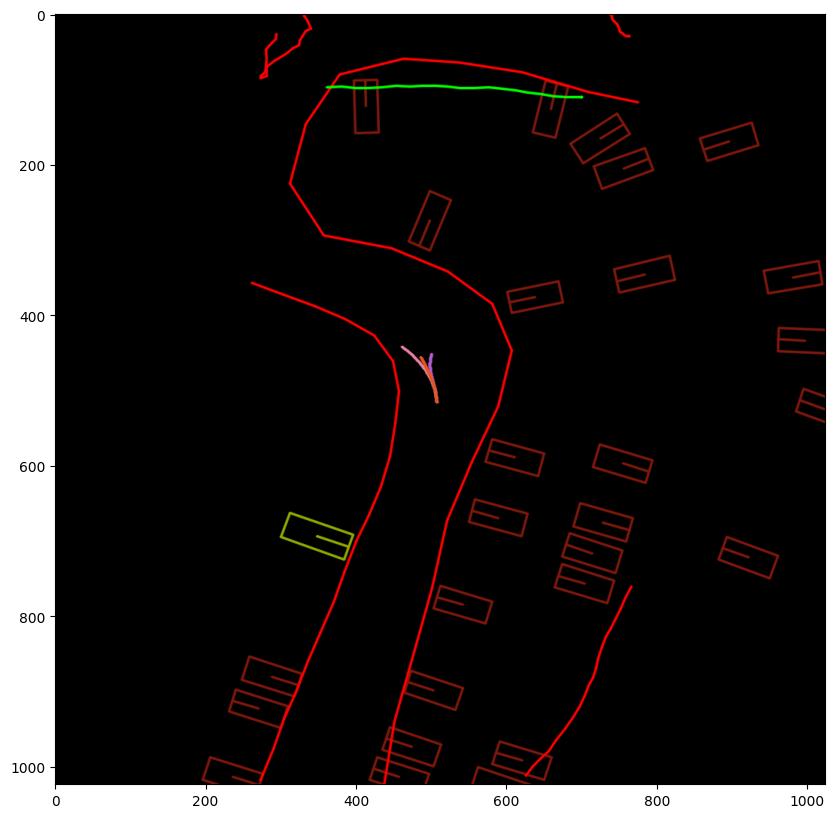

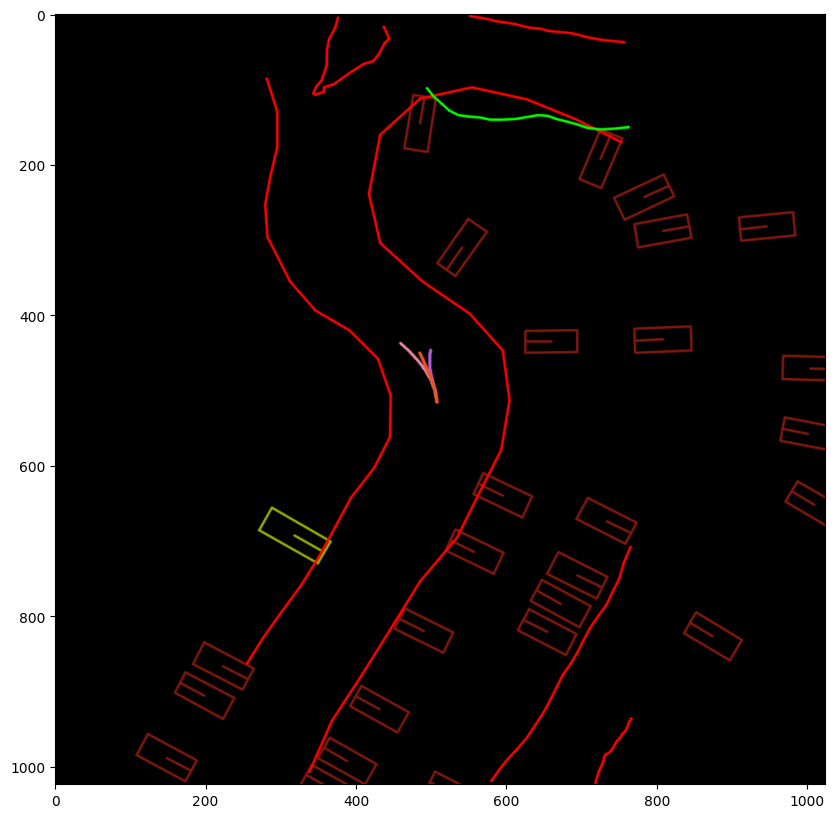

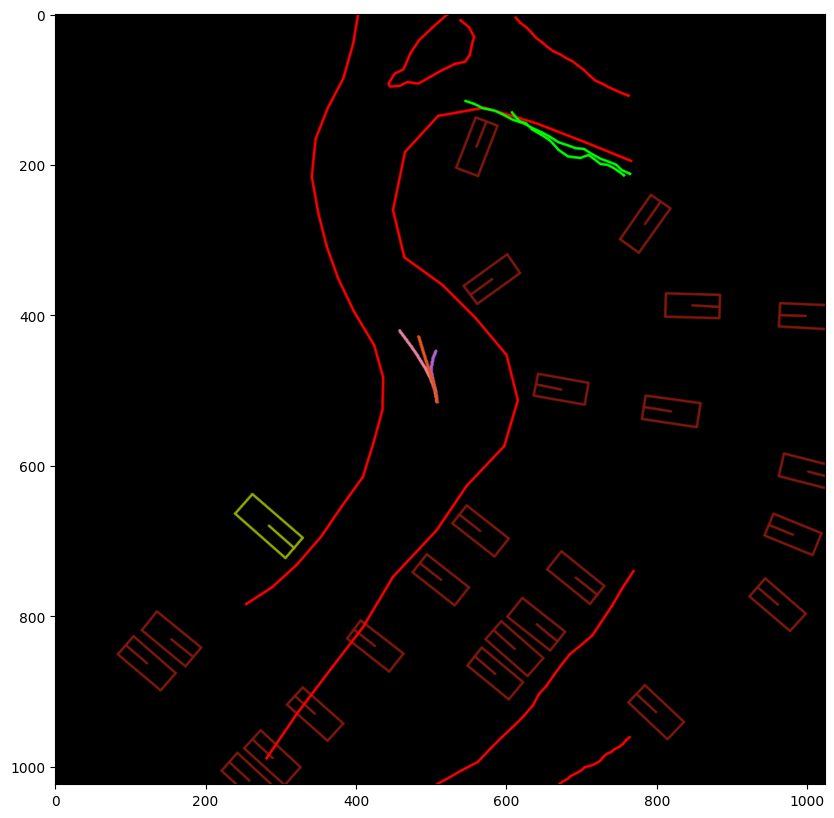

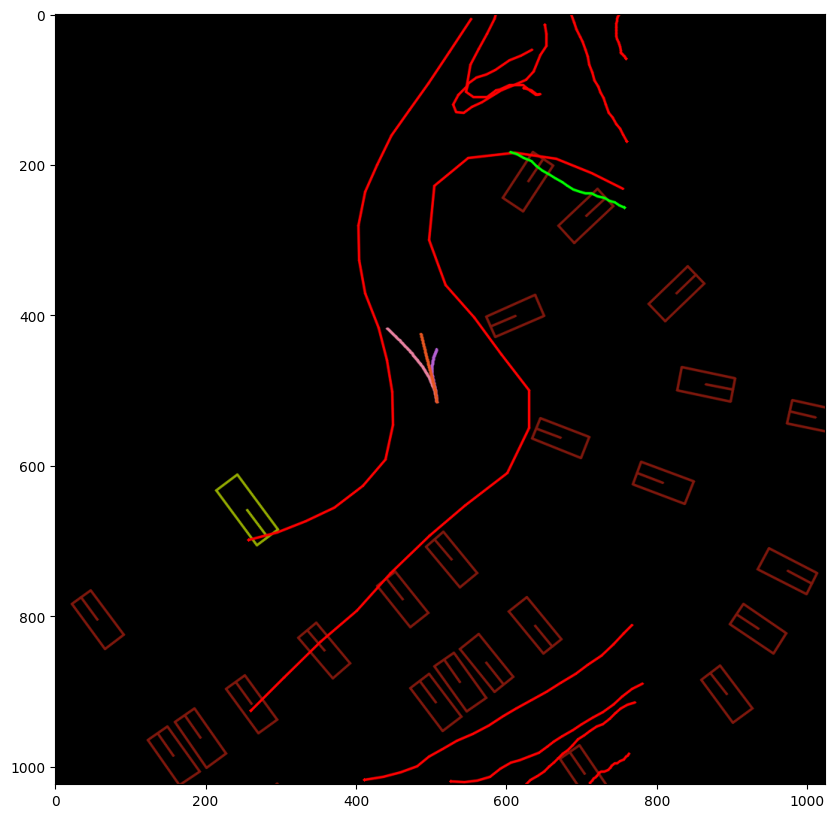

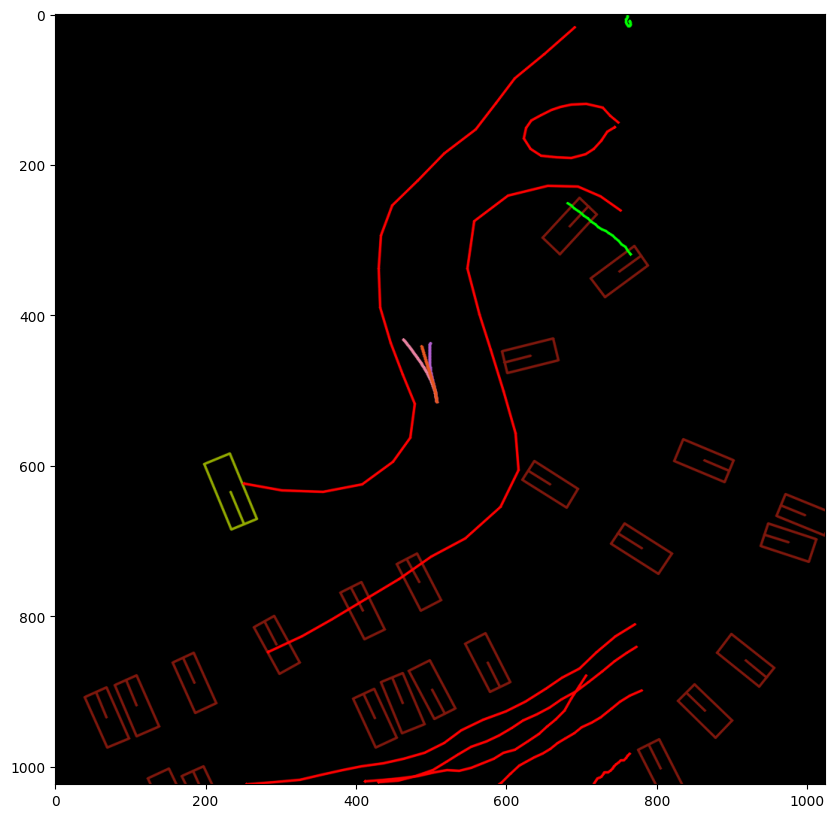

In [91]:

MAP_SIZE = 1024
COLOR_VECTORS = [(0, 0, 255), (0, 255, 0), (255, 0, 0), (255, 255, 0), (0, 255, 255), (255, 0, 255)]
MAP_SCORE_THRESH = 0.3
SCORE_THRESH = 0.3

for result in result_all:
    plt.figure(figsize=(10, 10))
    img = np.zeros((MAP_SIZE, MAP_SIZE, 3), dtype=np.uint8)

    result = result['img_bbox']

    bboxes = result['boxes_3d']
    for i in range(result['labels_3d'].shape[0]):
        score = result['scores_3d'][i]
        if score < SCORE_THRESH: 
            continue
        color = color_mapping[result['labels_3d'][i]]
        color = tuple(int(c) for c in color)
        # print('cls', result['labels_3d'][i])

        
        corners = box3d_to_corners(bboxes)[i, [0, 3, 7, 4, 0]]


        # draw front center line
        forward_center = np.mean(corners[2:4], axis=0)
        center = np.mean(corners[0:4], axis=0)
        x = [forward_center[0], center[0]]
        y = [forward_center[1], center[1]]

        x = [(i / 60 + 0.5) * MAP_SIZE for i in x]
        y = [(1 - (i / 60 + 0.5)) * MAP_SIZE for i in y]
        
        img = cv2.line(img, (int(x[0]), int(y[0]),), (int(x[1]), int(y[1])), color, 2, cv2.LINE_AA)

        # draw bbox
        x = corners[:, 0]
        y = corners[:, 1]

        
        x = (x / 60 + 0.5) * MAP_SIZE
        y = (1 - (y / 60 + 0.5)) * MAP_SIZE
        img = cv2.polylines(img, np.array([np.stack([x, y], axis=1)], dtype=np.int32), isClosed=True, color=color, thickness=2, lineType=cv2.LINE_AA)
    
    for i in range(result['scores'].shape[0]):
        score = result['scores'][i]
        if  score < MAP_SCORE_THRESH:
            continue
        color = COLOR_VECTORS[result['labels'][i]]
        # color = (0, 0, 255)
        pts = result['vectors'][i].copy()
        pts[:, 0] = (pts[:, 0] / 60 + 0.5) * MAP_SIZE # x
        pts[:, 1] = (1 - (pts[:, 1] / 60 + 0.5)) * MAP_SIZE # y

    
        img = cv2.polylines(img, np.array([pts], dtype=np.int32), isClosed=False, color=color, thickness=2, lineType=cv2.LINE_AA)
        img = cv2.circle(img, (int(pts[0, 0]), int(pts[0, 1])), 2, color, -1)
    
    traj_all = draw_planning_pred(result)

    # traj = np.mean(traj_all, axis=0)
    colors = [(179, 96, 209), (232, 130, 161), (230, 85, 32)]
    for i, traj in enumerate(traj_all):

        traj = -traj + 0.5
        traj[:, 0] = -traj[:, 0]
        traj *= 8
        traj += MAP_SIZE // 2


        img = cv2.polylines(img, np.array([traj], dtype=np.int32), isClosed=False, color=colors[i], thickness=2, lineType=cv2.LINE_AA)

    plt.imshow(img)
    plt.show()

    # break
# for i in range(result['scores'].shape[0]):
#     score = result['scores'][i]
#     if  score < MAP_SCORE_THRESH:
#         continue
#     color = COLOR_VECTORS[result['labels'][i]]
#     pts = result['vectors'][i]
#     x = pts[:, 0] / 30 + 0.5
#     y = pts[:, 1] / 60 + 0.5
#     plt.plot(x, y, color=color, linewidth=3, marker='o', linestyle='-', markersize=7)

In [74]:
traj.tolist()[:]

[]